In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code


In [2]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [ ]:
data_dir='../../output/figures/'
fig_dir='../../output/data/'

In [3]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=7.5 #para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0
blockname=('slow block','fast block')
block_times=[150,50]
from lib.filter_lib import *
from lib.filter_plotting import *

In [4]:
from lib.dyn_prog_model import get_pt_plus
from lib.lib import get_trajs
from seaborn import color_palette

In [5]:
df_traj=get_trajs() #loads all possible token trajectories for default settings

## Periodic alpha dynamics (fig.2 & supp. fig. 2)

Generate simulated trial sequence

In [183]:
num_blocks=500
block_size=300
alpha_sequence=np.zeros(num_blocks)
alpha_sequence[1::2]=1/4
alpha_sequence[::2]=3/4
alpha_sequence=np.repeat(alpha_sequence,[block_size]*num_blocks)
num_trials=len(alpha_sequence)

np.random.seed(0)
df_sim=df_traj.sample(num_trials,replace=True).reset_index(drop=True)
df_sim['nPostInterval']=(1-alpha_sequence)*200
df_sim['block_idx']=np.repeat(np.arange(num_blocks),[block_size]*num_blocks)
df_sim['dDate']=np.nan

In [211]:
model_paras_S1_taus={'tau_context':20*10, #about trial duration x10
                'sense_power':9,        #approximately the value learned from subject 1
                'tau_long':block_size*20*10,     #
                'unitconv':1
                }
df_mod=get_model_output(df_sim,model_paras_S1_taus)
df_mod['Nt']=df_sim.Nt
df_mod['p_plus']=df_sim.p_plus
df_mod['p_success']=df_sim.p_success

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


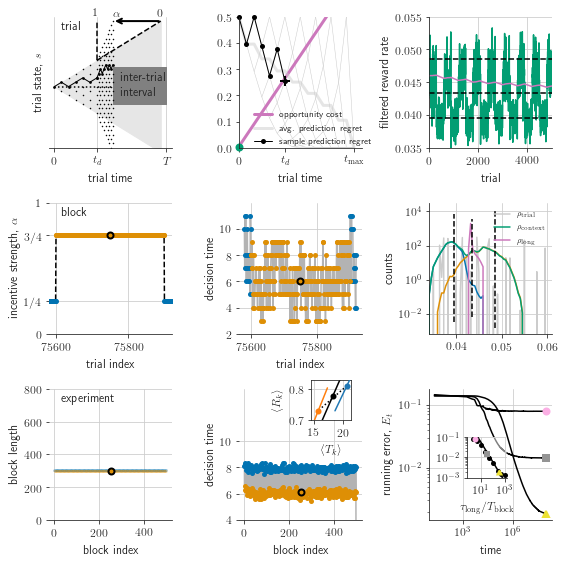

In [213]:
df_tmp=df_mod

colors=color_palette("colorblind", 10)
colreg=colors[0]
collong=colors[4]
colcon=colors[2]

df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
df_tmp['block_len']=0
block_len_range=[-1,np.Inf]
df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.
nblocks=(df_tmp.block_len>0).sum()

block_choice=int(nblocks/2)+2
block_ind=df_tmp.loc[cond].index.values[block_choice]
margin_size=20
block_range=(block_ind-margin_size,block_ind+df_tmp.loc[block_ind].block_len+margin_size)
traj_it=block_ind+int(df_tmp.loc[block_ind].block_len/2) #set as half way through block
alp=1-df_tmp.loc[traj_it].nPostInterval/200
Nt_traj=df_tmp.loc[traj_it].Nt

Tdec=df_tmp.loc[traj_it].tDecision

fig,ax=pl.subplots(3,3,figsize=(8,8))

tlim=(2,12)

#experiment
axind=(2,0)
ax[axind].plot(df_tmp[cond].block_len.values,'-',color=[0.7]*3)
tmp=df_tmp[cond].reset_index(drop=True)
for it in range(2):
    ax[axind].plot(tmp[tmp.nPostInterval==block_times[it]].block_len+2*(-1)**it,'.',color=colors[it],label=blockname[it],ms=0.3)
ax[axind].plot([block_choice],[df_tmp.loc[block_ind].block_len],'o',mec='k',mfc=colors[1])
ax[axind].text(0.1,0.9,'experiment',transform=ax[axind].transAxes)
ax[axind].set_ylim(0,2*block_size)#2000)
ax[axind].set_ylabel('block length')
ax[axind].set_xlabel('block index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)

#block
axind=(1,0)
ax[axind].text(0.1,0.9,'block',transform=ax[axind].transAxes)
ax[axind].plot(1-df_tmp.iloc[block_range[0]:block_range[1]].nPostInterval/200,'k--')
alpvec=1-df_tmp.iloc[block_range[0]:block_range[1]].nPostInterval/200
ax[axind].plot(alpvec[alpvec==1/4],'.',color=colors[0])
ax[axind].plot(alpvec[alpvec==3/4],'.',color=colors[1])
ax[axind].plot([traj_it],[1-df_tmp.iloc[traj_it].nPostInterval/200],'o',mec='k',mfc='None')
ax[axind].set_ylim(0,1)
ax[axind].set_yticks([0,0.25,0.75,1])
ax[axind].set_yticklabels([r'$0$',r'$1/4$',r'$3/4$',r'$1$'])
ax[axind].set_ylabel(r'incentive strength, $\alpha$')
ax[axind].set_xlabel('trial index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].set_xlim(block_range)

#evidence space
axind=(0,0)
ax[axind].text(0.1,0.9,'trial',transform=ax[axind].transAxes)
for Nm in np.arange(Tdec):
    ax[axind].plot(np.arange(Tdec+1-Nm)+Nm,np.arange(Tdec+1-Nm)-Nm,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].plot([Tdec],[-Tdec],'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].fill_between(np.arange(para['T']+1),-np.arange(para['T']+1),np.arange(para['T']+1),color=[0.9]*3)
ax[axind].plot(np.arange(Tdec,para['T']+1),np.arange(Tdec,para['T']+1),'k--')
ax[axind].plot([Tdec]*2,[Tdec,para['T']],'k--')
arrow_start=(para['T'],para['T'])
arrow_end=(Tdec+(1-alp)*(para['T']-Tdec),para['T'])
ax[axind].annotate("",xy=arrow_end,xycoords='data',
               xytext=arrow_start,textcoords='data',
               arrowprops=dict(arrowstyle="->",connectionstyle='arc3',lw=2,color='k'))
ax[axind].text(Tdec-0.5,para['T']+1,r'$1$')
ax[axind].text(para['T']-0.5,para['T']+1,r'$0$')
ax[axind].text(arrow_end[0],para['T']+1,r'$\alpha$')
trial_end=Tdec+(1-alp)*(para['T']-Tdec)
ax[axind].plot([0,trial_end],[0]*2,'k:')
ax[axind].fill_between([trial_end,trial_end+para['T_ITI']],[-4]*2,[4.5]*2,color=[0.5]*3)
ax[axind].text(Tdec+(1-alp)*(para['T']-Tdec)+1,-2,"inter-trial \n interval")
for t in np.arange(Tdec,para['T']):
    ax[axind].plot(Tdec+(1-alp)*(t-Tdec+1)*np.ones(t+2),np.arange(-(t+1),t+2,2),'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].plot(Nt_traj[:Tdec+1],'k.-',ms=1.5,lw=1)
ax[axind].plot(Tdec+(1-alp)*np.arange(para['T']-Tdec+1),Nt_traj[Tdec:],'k.-',ms=1.5,lw=1)

#formatting
ax[axind].set_ylim(-para['T']+1,para['T']+1)
ax[axind].set_xticks([0,Tdec,trial_end+para['T_ITI']])
ax[axind].set_yticks([])
ax[axind].set_xticklabels([r'$0$',r'$t_d$',r'$T$'])
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].set_xlabel('trial time')
ax[axind].set_ylabel(r'trial state, $s$')

#experiment response
axind=(1,1)

#response times over block
tmp=df_tmp.iloc[block_range[0]:block_range[1]]
ax[axind].plot(tmp.tDecision,'-',color=[0.7]*3)
ax[axind].plot(tmp[tmp.nPostInterval==150].tDecision,'.',color=colors[0])
ax[axind].plot(tmp[tmp.nPostInterval==50].tDecision,'.',color=colors[1])
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].plot([traj_it],[tmp.loc[traj_it].tDecision],'o',mec='k',mfc=colors[1])
ax[axind].set_yticks(range(2,12,2))
ax[axind].set_ylim(tlim)
ax[axind].set_xlabel('trial index')
ax[axind].set_ylabel('decision time')

axind=(2,1)
inds=df_tmp[cond].index.values
tStore=np.zeros(cond.sum())
fast_ind=np.zeros(cond.sum(),dtype=bool)
for it, ind in enumerate(inds[:-1]):
    late_Start=0
    if inds[it+1]-ind>late_Start:
        tStore[it]=df_tmp.iloc[ind+late_Start:inds[it+1]].tDecision.mean()
    fast_ind[it]=(df_tmp.iloc[ind].nPostInterval==50)
ax[axind].plot(tStore,'-',color=[0.7]*3)
ax[axind].plot(np.array(np.where(fast_ind))[0],tStore[fast_ind],'.',color=colors[1])
ax[axind].plot(np.array(np.where(~fast_ind))[0],tStore[~fast_ind],'.',color=colors[0])
ax[axind].plot([block_choice],[tStore[block_choice]],'o',mfc=colors[1],mec='k')
ax[axind].set_ylim(ax[1,1].get_ylim())
ax[axind].set_ylabel('block averaged decision time')
ax[axind].set_yticks(range(2,12,2))
ax[axind].set_ylabel('decision time')
ax[axind].set_ylim((4,14))
ax[axind].set_xlabel('block index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)

axind=(0,1)
trial_time_vec=np.arange(len(df_mod.iloc[0].seq)+1)
sample_trial=df_mod.iloc[traj_it]
t_decision=sample_trial.tDecision
urgency=(sample_trial.rho_context-sample_trial.rho_long)*sample_trial.T_context+sample_trial.rho_long*trial_time_vec
for Nm in np.arange(para['T'],dtype=int):
    ax[axind].plot(np.arange(para['T']+1-Nm)+Nm,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm)+Nm,np.arange(para['T']+1-Nm)-Nm)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
for Np in np.arange(para['T']):
    ax[axind].plot(np.arange(para['T']+1-Np)+Np,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np)+Np,np.arange(para['T']+1-Np)-Np)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
ax[axind].plot(trial_time_vec,urgency,'-',color=collong,lw=3,label='opportunity cost')
data=df_tmp.p_success.tolist()
mean_regret=1-np.mean(data,axis=0)
ax[axind].plot(np.arange(para['T']+1),mean_regret,'-',color=[0.8]*3,alpha=0.5,lw=3,label='avg. prediction regret')
regret=1-df_tmp.iloc[traj_it].p_success[:t_decision+1]
ax[axind].plot(range(t_decision+1),regret[:t_decision+1],'.-',color='k',lw=1,label='sample prediction regret',clip_on=False)
ax[axind].plot([0],[urgency[0]],'o',color=colcon,clip_on=False)

ax[axind].plot([t_decision],[regret[t_decision]],'k+',ms=10,clip_on=False)
ax[axind].set_xlabel('trial time')
ax[axind].set_ylim(0,0.5)
ax[axind].set_xticks((0,Tdec,para['T']))
ax[axind].set_xticklabels((r'$0$',r'$t_d$',r'$t_\textrm{max}$'))
ax[axind].set_xlim(0,para['T']+1)
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].grid('False')

axind=(0,2)
ax[axind].plot(df_mod.rho_context,color=colcon)
ax[axind].plot(df_mod.rho_long,color=collong)
ax[axind].set_xlabel('trial')
ax[axind].set_ylabel('filtered reward rate')
ax[axind].set_xlim(0,5000)#traj_it)
for condtmp in (df_tmp.index,df_tmp.nPostInterval==150,df_tmp.nPostInterval==50):
    ax[axind].plot(ax[axind].get_xlim(),[(df_tmp.loc[condtmp].nChoiceMade==df_tmp.loc[condtmp].nCorrectChoice).sum()/df_tmp.loc[condtmp].duration.sum()]*2,'k--')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].set_ylim(0.035,0.055)

# left, bottom, width, height = [0.88, 0.92, 0.06, 0.06] #outset
# axin2b = fig.add_axes([left, bottom, width, height])
# left, bottom, width, height = [0.78, 0.92, 0.06, 0.06] #outset
# axin2a = fig.add_axes([left, bottom, width, height])
# cols=(colors[2],colors[4])
# for it,measure in enumerate(('rho_context','rho_long')):
#     timevec,data_store=get_transition_ensemble(df_tmp,measure)
#     for pit,data in enumerate(data_store):
#         me=np.mean(data,axis=0)
#         axin2b.plot(me[:-1],np.diff(me),color=cols[it])
#         axin2a.plot(timevec,me,color=cols[it])
# axin2b.set_yticks([])#yaxis.tick_right()
# axin2b.set_xticks([])#.xaxis.tick_top()
# axin2b.set_ylabel(r'$\dot{\rho}$')
# axin2b.set_xlabel(r'$\rho$')
# axin2b.spines['bottom'].set_position('zero')
# axin2b.spines['right'].set_visible(False)
# axin2b.spines['top'].set_visible(False)
# axin2b.spines['left'].set_visible(False)
# axin2a.set_yticks([])#yaxis.tick_right()
# axin2a.set_xticks([])#.xaxis.tick_top()
# axin2a.set_ylabel(r'$\rho$')
# axin2a.spines['bottom'].set_visible(False)
# axin2a.spines['right'].set_visible(False)
# axin2a.spines['top'].set_visible(False)
# axin2a.spines['left'].set_position('zero')


axind=(1,2)
coltmp=(colcon,collong)
bins=np.linspace(0.025,0.07,100)
counts,bins=np.histogram(df_tmp.trialRR.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=[0.8]*3,label=r'$\rho_\textrm{trial}$')
Tfast=df_tmp[df_tmp.nPostInterval==50].T_context.mean()
Tslow=df_tmp[df_tmp.nPostInterval==150].T_context.mean()
for it,condtmp in enumerate((df_tmp.nPostInterval==150,df_tmp.nPostInterval==50)):
    counts,bins=np.histogram(df_tmp.loc[condtmp].rho_context.values,bins,density=True)
    Ttmp=df_tmp.loc[condtmp].T_context.mean()
    ax[axind].plot(bins[:-1],Ttmp*counts/(Tfast+Tslow),'-',color=colors[it])
counts,bins=np.histogram(df_tmp.rho_context.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=colcon,label=r'$\rho_\textrm{context}$')
counts,bins=np.histogram(df_tmp.rho_long.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=collong,label=r'$\rho_\textrm{long}$')
ax[axind].set_yscale('log')
for condtmp in (df_tmp.index,df_tmp.nPostInterval==150,df_tmp.nPostInterval==50):
    ax[axind].plot([(df_tmp.loc[condtmp].nChoiceMade==df_tmp.loc[condtmp].nCorrectChoice).sum()/df_tmp.loc[condtmp].duration.sum()]*2,ax[axind].get_ylim(),'k--')
ax[axind].set_xlim(0.034,0.061)
ax[axind].legend(frameon=False,loc=1,prop={'size':8})
ax[axind].set_ylabel('counts')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)


left, bottom, width, height = [0.55, 0.26, 0.07, 0.07] #outset
axin = fig.add_axes([left, bottom, width, height])

rho_context=[df_mod[df_mod.nPostInterval==n].rho_context.mean() for n in (150,50)]#[0.035,0.046]
T_context=[df_mod[df_mod.nPostInterval==n].duration.mean() for n in (150,50)]#[0.035,0.046][24,16]
T_avg=df_mod.duration.mean()#sum(T_context)/2
R_context=[rho*T for rho,T in zip(rho_context,T_context)]
R_avg=sum([R*T/sum(T_context) for R,T in zip(R_context,T_context)])

trial_time_vec=np.arange(para['T']+1+para['T_ITI'])
axin.set_ylim(0.70,0.83)
axin.set_xlim((para['T']+1+para['T_ITI']-9,para['T']+1+para['T_ITI']-2))
axin.set_ylabel(r'$\langle R_k\rangle$')
axin.set_xlabel(r'$\langle T_k\rangle$')
axin.plot(T_context,R_context,':',color='k')
axin.plot([0.9*T_avg,1.1*T_avg],[0.9*R_avg,1.1*R_avg],'-',color='k')
for it,lbl in enumerate(blockname):
    axin.plot([T_context[it]],[R_context[it]],'o',color='C'+str(it),ms=4,label=lbl,zorder=4)
    axin.plot([0.9*T_context[it],1.1*T_context[it]],[0.9*R_context[it],1.1*R_context[it]],'-',color='C'+str(it),ms=4,zorder=4)
axin.plot([T_avg],[R_avg],'o',color='k',ms=4,label='time-averaged')


axind=(2,2)
error_store=np.load('error_store.npy')
error_store2=np.load('errorstore2.npy')
times_store=np.load('times_store.npy')
mrkvec=['o','s','^']
for it in range(3):
    step=100
    running_avg_diff=error_store[it]
    ax[axind].plot(times_store[it],running_avg_diff,'k')
    ax[axind].plot([times_store[it][-1]],running_avg_diff[-1],mrkvec[it],color=colors[6+it])
    ax[axind].set_xscale('log')
    ax[axind].set_yscale('log')
ax[axind].set_xlabel(r'time')
ax[axind].set_ylabel(r'running error, $E_t$')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)

left, bottom, width, height = [0.82, 0.16, 0.07, 0.07] #outset
axin = fig.add_axes([left, bottom, width, height])
tau_long_vec=[1e3,1e4,1e5]
block_size_vec=[100,200,400]
for tit,tau_long in enumerate(tau_long_vec):
    for bit,block_size in enumerate(block_size_vec):
        axin.plot([tau_long/block_size],[error_store2[tit,bit]],'k.')
for it in range(3):
    step=100
    running_avg_diff=error_store[it]
    axin.plot([tau_long_vec[it]/300],[running_avg_diff[-1]],mrkvec[it],ms=4,color=colors[6+it],zorder=4)        
xvar=np.logspace(0,3,100)
axin.plot(xvar,0.6*xvar**(-1),'k-')
axin.set_xlabel(r'$\tau_\textrm{long}/T_\textrm{block}$')
axin.set_xscale('log')
axin.set_yscale('log')
axin.set_ylim(1e-3,1e-1)
axin.spines['right'].set_visible(False)
axin.spines['top'].set_visible(False)
axin.patch.set_alpha(0.5)

fig.tight_layout()
axind=(0,1)
ax[axind].legend(frameon=False,prop={'size':9},loc='lower center',bbox_to_anchor=[0.6,-0.05])

# fig.savefig('multiple_timescale_test.pdf', transparent=True,bbox_inches='tight',dpi=300)

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


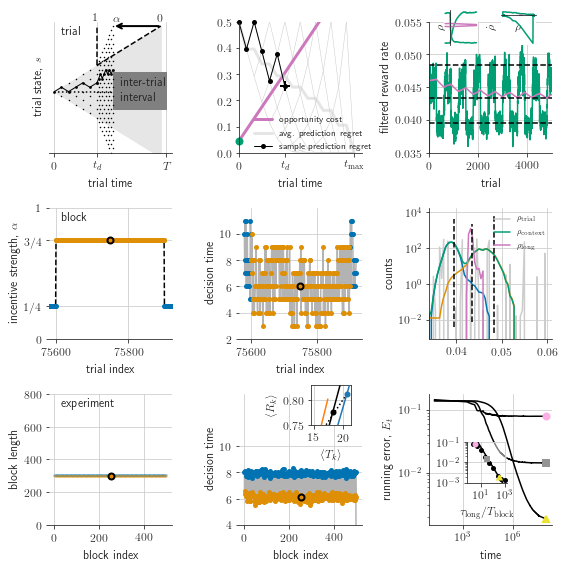

In [43]:
df_tmp=df_mod

colors=color_palette("colorblind", 10)
colreg=colors[0]
collong=colors[4]
colcon=colors[2]

df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
df_tmp['block_len']=0
block_len_range=[-1,np.Inf]
df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.
nblocks=(df_tmp.block_len>0).sum()

block_choice=int(nblocks/2)+2
block_ind=df_tmp.loc[cond].index.values[block_choice]
margin_size=20
block_range=(block_ind-margin_size,block_ind+df_tmp.loc[block_ind].block_len+margin_size)
traj_it=block_ind+int(df_tmp.loc[block_ind].block_len/2) #set as half way through block
alp=1-df_tmp.loc[traj_it].nPostInterval/200
Nt_traj=df_tmp.loc[traj_it].Nt

Tdec=df_tmp.loc[traj_it].tDecision

fig,ax=pl.subplots(3,3,figsize=(8,8))

tlim=(2,12)

#experiment
axind=(2,0)
ax[axind].plot(df_tmp[cond].block_len.values,'-',color=[0.7]*3)
tmp=df_tmp[cond].reset_index(drop=True)
for it in range(2):
    ax[axind].plot(tmp[tmp.nPostInterval==block_times[it]].block_len+2*(-1)**it,'.',color=colors[it],label=blockname[it],ms=0.3)
ax[axind].plot([block_choice],[df_tmp.loc[block_ind].block_len],'o',mec='k',mfc=colors[1])
ax[axind].text(0.1,0.9,'experiment',transform=ax[axind].transAxes)
ax[axind].set_ylim(0,2*block_size)#2000)
ax[axind].set_ylabel('block length')
ax[axind].set_xlabel('block index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)

#block
axind=(1,0)
ax[axind].text(0.1,0.9,'block',transform=ax[axind].transAxes)
ax[axind].plot(1-df_tmp.iloc[block_range[0]:block_range[1]].nPostInterval/200,'k--')
alpvec=1-df_tmp.iloc[block_range[0]:block_range[1]].nPostInterval/200
ax[axind].plot(alpvec[alpvec==1/4],'.',color=colors[0])
ax[axind].plot(alpvec[alpvec==3/4],'.',color=colors[1])
ax[axind].plot([traj_it],[1-df_tmp.iloc[traj_it].nPostInterval/200],'o',mec='k',mfc='None')
ax[axind].set_ylim(0,1)
ax[axind].set_yticks([0,0.25,0.75,1])
ax[axind].set_yticklabels([r'$0$',r'$1/4$',r'$3/4$',r'$1$'])
ax[axind].set_ylabel(r'incentive strength, $\alpha$')
ax[axind].set_xlabel('trial index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].set_xlim(block_range)

#evidence space
axind=(0,0)
ax[axind].text(0.1,0.9,'trial',transform=ax[axind].transAxes)
for Nm in np.arange(Tdec):
    ax[axind].plot(np.arange(Tdec+1-Nm)+Nm,np.arange(Tdec+1-Nm)-Nm,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].plot([Tdec],[-Tdec],'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].fill_between(np.arange(para['T']+1),-np.arange(para['T']+1),np.arange(para['T']+1),color=[0.9]*3)
ax[axind].plot(np.arange(Tdec,para['T']+1),np.arange(Tdec,para['T']+1),'k--')
ax[axind].plot([Tdec]*2,[Tdec,para['T']],'k--')
arrow_start=(para['T'],para['T'])
arrow_end=(Tdec+(1-alp)*(para['T']-Tdec),para['T'])
ax[axind].annotate("",xy=arrow_end,xycoords='data',
               xytext=arrow_start,textcoords='data',
               arrowprops=dict(arrowstyle="->",connectionstyle='arc3',lw=2,color='k'))
ax[axind].text(Tdec-0.5,para['T']+1,r'$1$')
ax[axind].text(para['T']-0.5,para['T']+1,r'$0$')
ax[axind].text(arrow_end[0],para['T']+1,r'$\alpha$')
trial_end=Tdec+(1-alp)*(para['T']-Tdec)
ax[axind].plot([0,trial_end],[0]*2,'k:')
ax[axind].fill_between([trial_end,trial_end+para['T_ITI']],[-4]*2,[4.5]*2,color=[0.5]*3)
ax[axind].text(Tdec+(1-alp)*(para['T']-Tdec)+1,-2,"inter-trial \n interval")
for t in np.arange(Tdec,para['T']):
    ax[axind].plot(Tdec+(1-alp)*(t-Tdec+1)*np.ones(t+2),np.arange(-(t+1),t+2,2),'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
ax[axind].plot(Nt_traj[:Tdec+1],'k.-',ms=1.5,lw=1)
ax[axind].plot(Tdec+(1-alp)*np.arange(para['T']-Tdec+1),Nt_traj[Tdec:],'k.-',ms=1.5,lw=1)

#formatting
ax[axind].set_ylim(-para['T']+1,para['T']+1)
ax[axind].set_xticks([0,Tdec,trial_end+para['T_ITI']])
ax[axind].set_yticks([])
ax[axind].set_xticklabels([r'$0$',r'$t_d$',r'$T$'])
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].set_xlabel('trial time')
ax[axind].set_ylabel(r'trial state, $s$')

#experiment response
# for it, df_tmp in enumerate((df_tmp,df_mod)):
axind=(1,1)

#response times over block
tmp=df_tmp.iloc[block_range[0]:block_range[1]]
ax[axind].plot(tmp.tDecision,'-',color=[0.7]*3)
ax[axind].plot(tmp[tmp.nPostInterval==150].tDecision,'.',color=colors[0])
ax[axind].plot(tmp[tmp.nPostInterval==50].tDecision,'.',color=colors[1])
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
ax[axind].plot([traj_it],[tmp.loc[traj_it].tDecision],'o',mec='k',mfc=colors[1])
ax[axind].set_yticks(range(2,12,2))
ax[axind].set_ylim(tlim)
ax[axind].set_xlabel('trial index')
ax[axind].set_ylabel('decision time')

axind=(2,1)
inds=df_tmp[cond].index.values
tStore=np.zeros(cond.sum())
fast_ind=np.zeros(cond.sum(),dtype=bool)
for it, ind in enumerate(inds[:-1]):
    late_Start=0
    if inds[it+1]-ind>late_Start:
        tStore[it]=df_tmp.iloc[ind+late_Start:inds[it+1]].tDecision.mean()
    fast_ind[it]=(df_tmp.iloc[ind].nPostInterval==50)
ax[axind].plot(tStore,'-',color=[0.7]*3)
ax[axind].plot(np.array(np.where(fast_ind))[0],tStore[fast_ind],'.',color=colors[1])
ax[axind].plot(np.array(np.where(~fast_ind))[0],tStore[~fast_ind],'.',color=colors[0])
ax[axind].plot([block_choice],[tStore[block_choice]],'o',mfc=colors[1],mec='k')
ax[axind].set_ylim(ax[1,1].get_ylim())
ax[axind].set_ylabel('block averaged decision time')
ax[axind].set_yticks(range(2,12,2))
ax[axind].set_ylabel('decision time')
ax[axind].set_ylim((4,14))
ax[axind].set_xlabel('block index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)

axind=(0,1)
trial_time_vec=np.arange(len(df_mod.iloc[0].seq)+1)
sample_trial=df_mod.iloc[traj_it]
t_decision=sample_trial.tDecision
urgency=(sample_trial.rho_context-sample_trial.rho_long)*sample_trial.T_context+sample_trial.rho_long*trial_time_vec
for Nm in 2*np.arange(para['T']):
    ax[axind].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[axind].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.8]*3,mew=0.5,mfc='k',mec='k')
ax[axind].plot(trial_time_vec,urgency,'-',color=collong,lw=3,label='opportunity cost')
data=df_tmp.p_suc_seq.tolist()
mean_regret=1-np.mean(data,axis=0)
ax[axind].plot(np.arange(para['T']+1),mean_regret,'-',color=[0.8]*3,alpha=0.5,lw=3,label='avg. prediction regret')
regret=1-df_tmp.iloc[traj_it].p_suc_seq[:t_decision+1]
ax[axind].plot(range(t_decision+1),regret[:t_decision+1],'.-',color='k',lw=1,label='sample prediction regret',clip_on=False)
ax[axind].plot([0],[urgency[0]],'o',color=colcon,clip_on=False)

ax[axind].plot([t_decision],[regret[t_decision]],'k+',ms=10,clip_on=False)
ax[axind].set_xlabel('trial time')
ax[axind].set_ylim(0,0.5)
ax[axind].set_xticks((0,Tdec,para['T']))
ax[axind].set_xticklabels((r'$0$',r'$t_d$',r'$t_\textrm{max}$'))
ax[axind].set_xlim(0,para['T']+1)
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].grid('False')

axind=(0,2)
ax[axind].plot(df_mod.rho_context,color=colcon)
ax[axind].plot(df_mod.rho_long,color=collong)
ax[axind].set_xlabel('trial')
ax[axind].set_ylabel('filtered reward rate')
ax[axind].set_xlim(0,5000)#traj_it)
for condtmp in (df_tmp.index,df_tmp.nPostInterval==150,df_tmp.nPostInterval==50):
    ax[axind].plot(ax[axind].get_xlim(),[(df_tmp.loc[condtmp].nChoiceMade==df_tmp.loc[condtmp].nCorrectChoice).sum()/df_tmp.loc[condtmp].duration.sum()]*2,'k--')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].set_ylim(0.035,0.055)
left, bottom, width, height = [0.88, 0.92, 0.06, 0.06] #outset
axin2b = fig.add_axes([left, bottom, width, height])
left, bottom, width, height = [0.78, 0.92, 0.06, 0.06] #outset
axin2a = fig.add_axes([left, bottom, width, height])
cols=(colors[2],colors[4])
for it,measure in enumerate(('rho_context','rho_long')):
    timevec,data_store=get_transition_ensemble(df_tmp,measure)
    for pit,data in enumerate(data_store):
        me=np.mean(data,axis=0)
        axin2b.plot(me[:-1],np.diff(me),color=cols[it])
        axin2a.plot(timevec,me,color=cols[it])
axin2b.set_yticks([])#yaxis.tick_right()
axin2b.set_xticks([])#.xaxis.tick_top()
axin2b.set_ylabel(r'$\dot{\rho}$')
axin2b.set_xlabel(r'$\rho$')
axin2b.spines['bottom'].set_position('zero')
axin2b.spines['right'].set_visible(False)
axin2b.spines['top'].set_visible(False)
axin2b.spines['left'].set_visible(False)
axin2a.set_yticks([])#yaxis.tick_right()
axin2a.set_xticks([])#.xaxis.tick_top()
axin2a.set_ylabel(r'$\rho$')
axin2a.spines['bottom'].set_visible(False)
axin2a.spines['right'].set_visible(False)
axin2a.spines['top'].set_visible(False)
axin2a.spines['left'].set_position('zero')


axind=(1,2)
coltmp=(colcon,collong)
bins=np.linspace(0.025,0.07,100)
counts,bins=np.histogram(df_tmp.trialRR.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=[0.8]*3,label=r'$\rho_\textrm{trial}$')
Tfast=df_tmp[df_tmp.nPostInterval==50].T_context.mean()
Tslow=df_tmp[df_tmp.nPostInterval==150].T_context.mean()
for it,condtmp in enumerate((df_tmp.nPostInterval==150,df_tmp.nPostInterval==50)):
    counts,bins=np.histogram(df_tmp.loc[condtmp].rho_context.values,bins,density=True)
    Ttmp=df_tmp.loc[condtmp].T_context.mean()
    ax[axind].plot(bins[:-1],Ttmp*counts/(Tfast+Tslow),'-',color=colors[it])
counts,bins=np.histogram(df_tmp.rho_context.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=colcon,label=r'$\rho_\textrm{context}$')
counts,bins=np.histogram(df_tmp.rho_long.values,bins,weights=df_tmp.T_context.values,density=True)
ax[axind].plot(bins[:-1],counts,color=collong,label=r'$\rho_\textrm{long}$')
ax[axind].set_yscale('log')
for condtmp in (df_tmp.index,df_tmp.nPostInterval==150,df_tmp.nPostInterval==50):
    ax[axind].plot([(df_tmp.loc[condtmp].nChoiceMade==df_tmp.loc[condtmp].nCorrectChoice).sum()/df_tmp.loc[condtmp].duration.sum()]*2,ax[axind].get_ylim(),'k--')
ax[axind].set_xlim(0.034,0.061)
ax[axind].legend(frameon=False,loc=1,prop={'size':8})
ax[axind].set_ylabel('counts')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)


left, bottom, width, height = [0.55, 0.26, 0.07, 0.07] #outset
axin = fig.add_axes([left, bottom, width, height])

rho_context=[df_mod[df_mod.nPostInterval==n].rho_context.mean() for n in (150,50)]#[0.035,0.046]
T_context=[df_mod[df_mod.nPostInterval==n].duration.mean() for n in (150,50)]#[0.035,0.046][24,16]
T_avg=df_mod.duration.mean()#sum(T_context)/2
R_context=[rho*T for rho,T in zip(rho_context,T_context)]
R_avg=sum([R*T/sum(T_context) for R,T in zip(R_context,T_context)])

trial_time_vec=np.arange(para['T']+1+para['T_ITI'])
axin.set_ylim(0.75,0.83)
axin.set_xlim((para['T']+1+para['T_ITI']-9,para['T']+1+para['T_ITI']-2))
axin.set_ylabel(r'$\langle R_k\rangle$')
axin.set_xlabel(r'$\langle T_k\rangle$')
axin.plot(T_context,R_context,':',color='k')
axin.plot([0.9*T_avg,1.1*T_avg],[0.9*R_avg,1.1*R_avg],'-',color='k')
for it,lbl in enumerate(blockname):
    axin.plot([T_context[it]],[R_context[it]],'o',color='C'+str(it),ms=4,label=lbl,zorder=4)
    axin.plot([0.9*T_context[it],1.1*T_context[it]],[0.9*R_context[it],1.1*R_context[it]],'-',color='C'+str(it),ms=4,zorder=4)
axin.plot([T_avg],[R_avg],'o',color='k',ms=4,label='time-averaged')


axind=(2,2)
error_store=np.load('error_store.npy')
error_store2=np.load('errorstore2.npy')
times_store=np.load('times_store.npy')
mrkvec=['o','s','^']
for it in range(3):
    step=100
    running_avg_diff=error_store[it]
    ax[axind].plot(times_store[it],running_avg_diff,'k')
    ax[axind].plot([times_store[it][-1]],running_avg_diff[-1],mrkvec[it],color=colors[6+it])
    ax[axind].set_xscale('log')
    ax[axind].set_yscale('log')
ax[axind].set_xlabel(r'time')
ax[axind].set_ylabel(r'running error, $E_t$')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)

left, bottom, width, height = [0.82, 0.16, 0.07, 0.07] #outset
axin = fig.add_axes([left, bottom, width, height])
tau_long_vec=[1e3,1e4,1e5]
block_size_vec=[100,200,400]
for tit,tau_long in enumerate(tau_long_vec):
    for bit,block_size in enumerate(block_size_vec):
        axin.plot([tau_long/block_size],[error_store2[tit,bit]],'k.')
for it in range(3):
    step=100
    running_avg_diff=error_store[it]
    axin.plot([tau_long_vec[it]/300],[running_avg_diff[-1]],mrkvec[it],ms=4,color=colors[6+it],zorder=4)        
xvar=np.logspace(0,3,100)
axin.plot(xvar,0.6*xvar**(-1),'k-')
axin.set_xlabel(r'$\tau_\textrm{long}/T_\textrm{block}$')
axin.set_xscale('log')
axin.set_yscale('log')
axin.set_ylim(1e-3,1e-1)
axin.spines['right'].set_visible(False)
axin.spines['top'].set_visible(False)
axin.patch.set_alpha(0.5)

fig.tight_layout()
axind=(0,1)
ax[axind].legend(frameon=False,prop={'size':9},loc='lower center',bbox_to_anchor=[0.6,-0.05])

# fig.savefig('multiple_timescale_test.pdf', transparent=True,bbox_inches='tight',dpi=300)

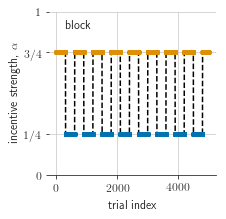

In [170]:
#block
df_tmp=df_mod
fig,ax=pl.subplots(figsize=(3,3))
ax=[ax]
axind=0
ax[axind].text(0.1,0.9,'block',transform=ax[axind].transAxes)
ax[axind].plot(1-df_tmp.iloc[:5000].nPostInterval/200,'k--')
alpvec=1-df_tmp.iloc[:5000].nPostInterval/200
ax[axind].plot(alpvec[alpvec==1/4],'.',color=colors[0])
ax[axind].plot(alpvec[alpvec==3/4],'.',color=colors[1])
# ax[axind].plot([traj_it],[1-df_tmp.iloc[traj_it].nPostInterval/200],'o',mec='k',mfc='None')
ax[axind].set_ylim(0,1)
ax[axind].set_yticks([0,0.25,0.75,1])
ax[axind].set_yticklabels([r'$0$',r'$1/4$',r'$3/4$',r'$1$'])
ax[axind].set_ylabel(r'incentive strength, $\alpha$')
ax[axind].set_xlabel('trial index')
ax[axind].spines['right'].set_visible(False)
ax[axind].spines['top'].set_visible(False)
ax[axind].spines['left'].set_visible(False)
# ax[axind].set_xlim(block_range)
fig.savefig('multiple_timescale_v3_block.pdf', transparent=True,bbox_inches='tight',dpi=300)

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:

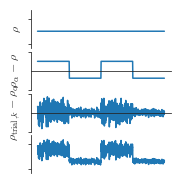

In [106]:
fig,ax=pl.subplots(4,1,figsize=(2.5,3))
# for it,rangevals in enumerate(([[30050,30250],[26000,34000],[20,int(1e5)]])):
rho_c=[]
for condtmp in (df_tmp.index,df_tmp.nPostInterval==150,df_tmp.nPostInterval==50):
    rho_c.append((df_tmp.loc[condtmp].nChoiceMade==df_tmp.loc[condtmp].nCorrectChoice).sum()/df_tmp.loc[condtmp].duration.sum())
df_mod['rho_c']=0
df_mod.loc[df_mod.nPostInterval==150,'rho_c']=rho_c[1]
df_mod.loc[df_mod.nPostInterval==50,'rho_c']=rho_c[2]
rangevals=[30000,31200]
trials=np.arange(rangevals[0],rangevals[1])
trial_noise=np.random.normal(0,0.004*(1-df_mod.iloc[rangevals[0]:rangevals[1]].nPostInterval/200))
ax[2].plot(trials,trial_noise)
# ax[2].plot(df_mod.iloc[rangevals[0]:rangevals[1]].trialRR-df_mod.iloc[rangevals[0]:rangevals[1]].rho_c)
ax[2].set_ylim(-0.01,0.01)
ax[2].spines['bottom'].set_position('zero')
ax[2].set_ylabel(r'$\rho_{\textrm{trial},k}-\rho_\alpha$')
ax[2].spines['bottom'].set_position('zero')
ax[2].set_yticks([-0.01,0.01])
ax[1].plot(df_mod.iloc[rangevals[0]:rangevals[1]].rho_c-rho_c[0])
ax[1].set_ylim(-0.01,0.01)
ax[1].set_ylabel(r'$\rho_\alpha-\rho$')
ax[1].spines['bottom'].set_position('zero')
ax[1].set_yticks([-0.01,0.01])


ax[0].plot(trials,rho_c[0]*np.ones(len(trials)))
ax[0].set_ylim(0.03,0.06)
ax[0].set_ylabel(r'$\rho$')
ax[0].spines['bottom'].set_visible(False)
ax[0].set_yticks([rho_c[0]-0.01,rho_c[0]+0.01])

ax[3].plot(trials,df_mod.iloc[rangevals[0]:rangevals[1]].rho_c+trial_noise)
ax[3].set_ylim(0.03,0.06)
ax[3].set_yticks([rho_c[0]-0.01,rho_c[0]+0.01])
ax[3].spines['bottom'].set_visible(False)

for axt in ax:
    axt.grid('off')
    axt.spines['right'].set_visible(False)
    axt.spines['top'].set_visible(False)
    axt.set_xticks([])
#     axt.set_yticks([0.041,0.045])
    axt.set_yticklabels('')
    
    
fig.subplots_adjust(hspace=0.1)
# fig.tight_layout()
fig.savefig('timescale_stack.pdf', transparent=True,bbox_inches='tight',dpi=300)

In [47]:
T_avg=20
block_size=300
T_exp=1e8
num_blocks=int(T_exp/T_avg/block_size)
max_trials=int(5e6)#num_blocks*block_size
df_sim=df_traj.sample(max_trials,replace=True).reset_index(drop=True)

In [43]:
error_store=[]
times_store=[]

alpha_sequence=np.zeros(num_blocks)
alpha_sequence[1::2]=1/4
alpha_sequence[::2]=3/4
alpha_sequence=np.repeat(alpha_sequence,[block_size]*num_blocks)
df_tmp=df_sim.iloc[:max_trials]
df_tmp['nPostInterval']=(1-alpha_sequence)*200
tau_long_vec=[1e3,1e4,1e5]
for tau_long in tau_long_vec:
    st=time.time()    

    model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
                    'sense_power':8.839935, 
                    'tau_long':tau_long,#31620.805644,
                    'Tcontext_bias':0,
                    'shared_noise_variance_factor':0,
                    'tau_shared_noise':30,
                    'context_noise_bias':0,
                    'context_noise_variance_factor':0
                    }
    df_mod=get_model_output(df_tmp,model_paras_S1_taus)
    rho_act=(df_mod.nChoiceMade==df_mod.nCorrectChoice).sum()/df_mod.duration.sum()

    error=np.cumsum(np.fabs(df_mod.rho_long.values-rho_act)*df_mod.duration)/df_mod.duration.cumsum()/rho_act
    step=100
    error_store.append(error[::step])
    times_store.append(df_mod.duration.cumsum()[::step])
    print(time.time()-st)

../lib/utils/ipynb_setup.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])


165.32414078712463
160.19071888923645
163.2341492176056


In [61]:
np.save('error_store.npy',error_store)
np.save('times_store.npy',times_store)

In [24]:
T_avg=20
block_size=300
T_exp=1e8

block_size_vec=[100,200,400]

num_blocks=int(T_exp/T_avg/block_size_vec[-1])
max_trials=num_blocks*block_size_vec[-1]

tau_long_vec=[1e3,1e4,1e5]

error_store2=np.zeros((len(tau_long_vec),len(block_size_vec)))
for tit,tau_long in enumerate(tau_long_vec):
    for bit,block_size in enumerate(block_size_vec):
        st=time.time() 
        num_blocks=int(max_trials/block_size)
        max_trials=num_blocks*block_size
        alpha_sequence=np.zeros(num_blocks)
        alpha_sequence[1::2]=1/4
        alpha_sequence[::2]=3/4
        alpha_sequence=np.repeat(alpha_sequence,[block_size]*num_blocks)
        df_tmp=df_sim.iloc[:max_trials]
        df_tmp['nPostInterval']=(1-alpha_sequence)*200
        model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
                        'sense_power':8.839935, 
                        'tau_long':tau_long,#31620.805644,
                        'Tcontext_bias':0,
                        'shared_noise_variance_factor':0,
                        'tau_shared_noise':30,
                        'context_noise_bias':0,
                        'context_noise_variance_factor':0
                        }
        df_mod=get_model_output(df_tmp,model_paras_S1_taus)
        rho_act=(df_mod.nChoiceMade==df_mod.nCorrectChoice).sum()/df_mod.duration.sum()
        error_store2[tit,bit]=np.sum(np.fabs(df_mod.rho_long.values-rho_act)*df_mod.duration)/df_mod.duration.sum()/rho_act
        print(time.time()-st)

../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


163.9348919391632


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


164.29370069503784


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


162.22065949440002


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


160.28687477111816


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


157.6804211139679


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


160.53868460655212


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


162.01286482810974


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


170.81704092025757


../lib/utils/ipynb_setup.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from importlib import reload


159.1015682220459


In [39]:
np.save('errorstore2.npy',error_store2)

In [330]:
from lib.filter_plotting import get_transition_ensemble

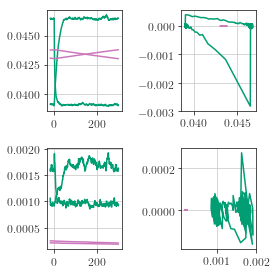

In [347]:
fig,ax=pl.subplots(2,2,figsize=(4,4))
win_size=1
dat=df_tmp.rho_context.rolling(window=win_size).mean()
cols=(colors[2],colors[4])
for it,measure in enumerate(('rho_context','rho_long')):
    timevec,data_store=get_transition_ensemble(df_tmp,measure)
    for pit,data in enumerate(data_store):
        me=np.mean(data,axis=0)
        std_dev=np.std(data,axis=0)
        ax[0,0].plot(timevec,me,color=cols[it])
        ax[1,0].plot(timevec,std_dev,color=cols[it])
        ax[0,1].plot(me[:-1],np.diff(me),color=cols[it])
        ax[1,1].plot(std_dev[:-1],np.diff(std_dev),color=cols[it])

fig.tight_layout()

## Response analysis on Thura data

Import data

In [90]:
import scipy.io as spio
mat = spio.loadmat('../../exp_data/Thura_etal_2016/toktrials.mat', squeeze_me=True)
col_names=mat['toktrials'].flatten().dtype.names
df_data=pd.DataFrame(columns=col_names)
for col_name in col_names:
    df_data[col_name]=mat['toktrials'].flatten()[0][col_name]

In [89]:
df_data.columns

Index(['Nt', 'seq', 'nPostInterval', 'idSubject', 'nCorrectChoice',
       'tDecision', 'nChoiceMade', 'dDate', 'block_idx', 'p_plus', 'p_success',
       'duration', 'trialRR'],
      dtype='object')

In [91]:
df_data.tFirstTokJump

0          610.0
1          742.0
2          788.0
3          744.0
4         1011.0
           ...  
213950     646.0
213951     739.0
213952     688.0
213953     655.0
213954     765.0
Name: tFirstTokJump, Length: 213955, dtype: float64

In [86]:
if not os.path.exists(os.getcwd()+'/../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl'):
    df_data=load_data()
# df_data.to_pickle('../../exp_data/Thura_etal_2016/df_data.pkl')
    df_data.to_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')

else:
#     df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data.pkl')
    df_data=pd.read_pickle('../../exp_data/Thura_etal_2016/df_data_tdec_as_int.pkl')
# subject=2
# df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)

In [92]:
df_data=load_data();

/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:33: SettingWithCopyWarning: 
A value is 

In [24]:
(df_data.dDate[1]-df_data.dDate[0]).total_seconds()

4.263

In [62]:
def dummy(row):
    if row.nPostInterval==150:
        return get_trial_duration(row.tDecision,0.25)*0.2
    else:
        return get_trial_duration(row.tDecision,0.75)*0.2
df_data['trialduration']=df_data.apply(dummy,axis=1)

In [61]:
def dummy(row):
    return row.total_seconds()
df_data['trialduration2']=df_data.dDate.diff().apply(dummy)

In [ ]:
def dummy(row):
    return row.total_seconds()
df_data['centertime']=df_data.dDate-df_

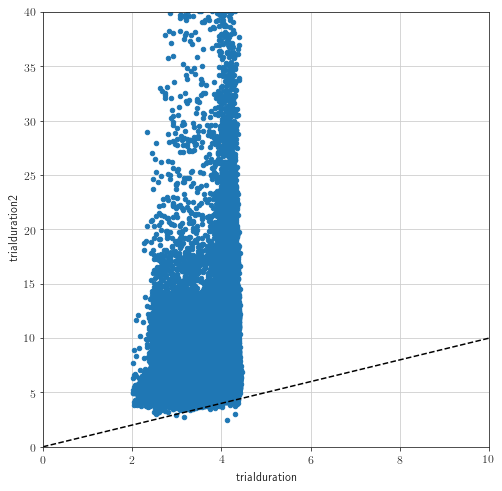

In [81]:

df_data.plot.scatter(x='trialduration',y='trialduration2',ylim=(0,40),xlim=(0,10))
pl.gca().plot(pl.gca().get_xlim(),pl.gca().get_xlim(),'k--')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd5ecf62840> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'trial_duration'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/max/.cache/matplotlib/tex.cache/7f11df599fed8edefa2cb6c48ab4d23e.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 2 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./7f11df599fed8edefa2cb6c48ab4d23e.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{12.000000}{15.000000}{\sffamily trial_
                                                  duration}
No pages of output.
Transcript written on 7f11df599fed8edefa2cb6c48ab4d23e.log.




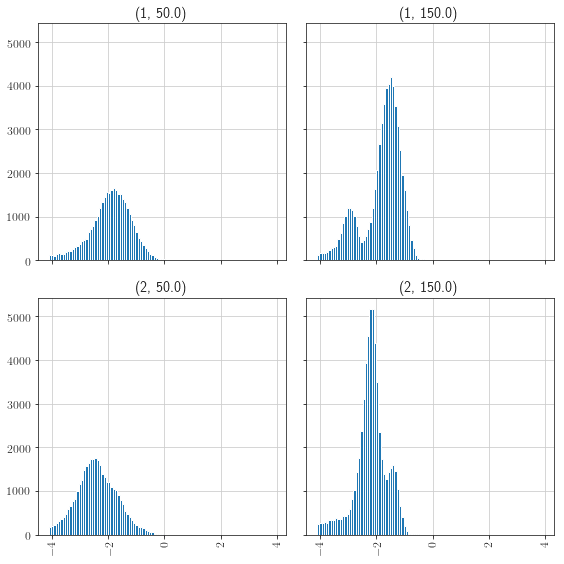

RuntimeError: latex was not able to process the following string:
b'trial_duration'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/max/.cache/matplotlib/tex.cache/7f11df599fed8edefa2cb6c48ab4d23e.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 2 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./7f11df599fed8edefa2cb6c48ab4d23e.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...ize{12.000000}{15.000000}{\sffamily trial_
                                                  duration}
No pages of output.
Transcript written on 7f11df599fed8edefa2cb6c48ab4d23e.log.




<Figure size 576x576 with 1 Axes>

In [58]:
(df_data.trial_duration-df_data.trial_duration_2).hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=(np.linspace(-20,20,100)-0.5)*0.2,density=False,sharey=True,sharex=True)
# df_data.trial_duration_2.hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=(np.linspace(10,40,100)-0.5)*0.2,density=False,sharey=True,sharex=True)

pl.gcf().tight_layout()
pl.gcf().savefig('trial_durations_formula_vs_diffTimeStamp.pdf', transparent=True,bbox_inches='tight',dpi=300)

In [101]:
df_data.columns

Index(['Nt', 'seq', 'nPostInterval', 'idSubject', 'nCorrectChoice',
       'tDecision', 'nChoiceMade', 'dDate', 'block_idx', 'tFirstTokJump',
       'p_plus', 'p_success', 'duration', 'trialRR'],
      dtype='object')

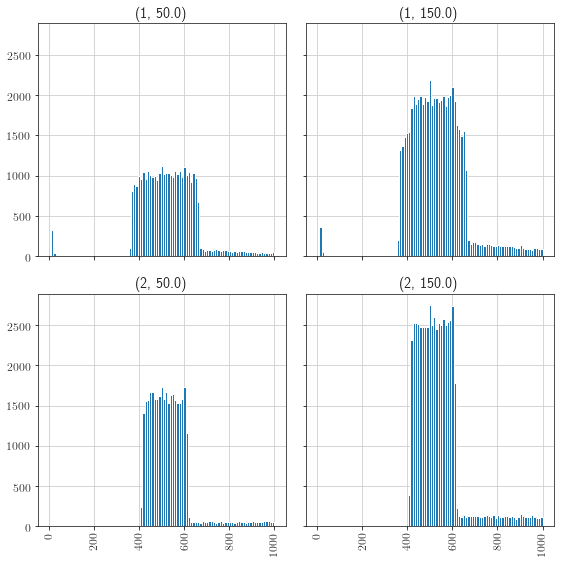

In [99]:
(df_data.tFirstTokJump-200).hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=np.linspace(0,1000,100),density=False,sharey=True,sharex=True)
pl.gcf().tight_layout()
pl.gcf().savefig('trial_centertime.pdf', transparent=True,bbox_inches='tight',dpi=300)

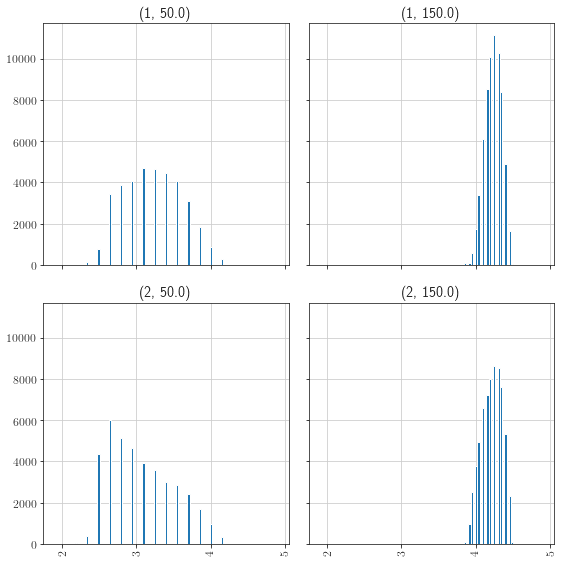

In [21]:
df_data.trial_duration.hist(by=[df_data['idSubject'],df_data['nPostInterval']],bins=(np.linspace(10,25,100)-0.5)*0.2,density=False,sharey=True,sharex=True)
pl.gcf().tight_layout()
pl.gcf().savefig('trial_durations.pdf', transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
            'sense_power':8.839935, 
            'tau_long':31620.805644,
            }
model_paras_S2_taus={'tau_context':1.40574372e+02, 
        'sense_power':-8.31123820e+00, 
        'tau_long':4.60248743e+04,
        }
model_paras_vec=[model_paras_S1_taus,model_paras_S2_taus]
sub_block_vec=[0,1]
for subject in [1,2]:
    df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)

    model_paras=model_paras_vec[subject-1]

    df_mod=get_model_output(df_act,model_paras,seed=10)
    
    plot_policies({'act':df_act,'mod':df_mod})#,file_name='subject_'+str(subject))

    fig,ax=pl.subplots(2,3,figsize=(8,5.5))
    title_str=['subject','fitted PGD agent']
    
    for tit, df_tmp in enumerate((df_act,df_mod)):

        df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
        df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
        cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
        df_tmp['block_len']=0
        block_len_range=[-1,np.Inf]
        df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.
        nblocks=(df_tmp.block_len>0).sum()

        block_choice=int(nblocks/2)+sub_block_vec[subject-1]
        block_ind=df_tmp.loc[cond].index.values[block_choice]
        margin_size=20
        block_range=(block_ind-margin_size,block_ind+df_tmp.loc[block_ind].block_len+margin_size)
        traj_it=block_ind+int(df_tmp.loc[block_ind].block_len/2) #set as half way through block
        alp=1-df_tmp.loc[traj_it].nPostInterval/200
#         Nt_traj=df_tmp.loc[traj_it].Nt

        Tdec=df_tmp.loc[traj_it].tDecision
        
        if tit==0:
            axind=(1,0)
            ax[axind].plot(df_tmp[cond].block_len.values,'-',color=[0.7]*3)
            tmp=df_tmp[cond].reset_index(drop=True)
            for it in range(2):
                ax[axind].plot(tmp[tmp.nPostInterval==block_times[it]].block_len,'.',color=colors[it],label=blockname[it],ms=1.5)
            ax[axind].plot([block_choice],[df_tmp.loc[block_ind].block_len],'o',mec='k',mfc=colors[1])
            ax[axind].set_ylim(0,2*block_size)#2000)
            ax[axind].set_ylabel('block length')
            ax[axind].set_xlabel('block index')
            ax[axind].spines['right'].set_visible(False)
            ax[axind].spines['top'].set_visible(False)
            ax[axind].spines['left'].set_visible(False)

        axind=(0,tit+1)

        #response times over block
        tmp=df_tmp.iloc[block_range[0]:block_range[1]]
        ax[axind].plot(tmp.tDecision,'-',color=[0.7]*3)
        ax[axind].plot(tmp[tmp.nPostInterval==150].tDecision,'.',color=colors[0],ms=1.5)
        ax[axind].plot(tmp[tmp.nPostInterval==50].tDecision,'.',color=colors[1],ms=1.5)
        ax[axind].spines['right'].set_visible(False)
        ax[axind].spines['top'].set_visible(False)
        ax[axind].spines['left'].set_visible(False)
        ax[axind].plot([traj_it],[tmp.loc[traj_it].tDecision],'o',mec='k',mfc=colors[1])
        ax[axind].set_yticks(range(0,14,2))
        ax[axind].set_ylim(0,14)
        ax[axind].set_xlabel('trial index')
        ax[axind].set_ylabel('decision time')
        ax[axind].set_title(title_str[tit])
        
        axind=(1,tit+1)
        inds=df_tmp[cond].index.values
        tStore=np.zeros(cond.sum())
        fast_ind=np.zeros(cond.sum(),dtype=bool)
        for it, ind in enumerate(inds[:-1]):
            late_Start=0
            if inds[it+1]-ind>late_Start:
                tStore[it]=df_tmp.iloc[ind+late_Start:inds[it+1]].tDecision.mean()
            fast_ind[it]=(df_tmp.iloc[ind].nPostInterval==50)
        ax[axind].plot(tStore,'-',color=[0.7]*3)
        ax[axind].plot(np.array(np.where(fast_ind))[0],tStore[fast_ind],'.',color=colors[1],ms=1.5)
        ax[axind].plot(np.array(np.where(~fast_ind))[0],tStore[~fast_ind],'.',color=colors[0],ms=1.5)
        ax[axind].plot([block_choice],[tStore[block_choice]],'o',mfc=colors[1],mec='k')
        ax[axind].set_ylim(ax[1,1].get_ylim())
        ax[axind].set_ylabel('block-avg. decision time')
        ax[axind].set_yticks(range(0,14,2))
        ax[axind].set_ylim((0,14))
        ax[axind].set_xlabel('block index')
        ax[axind].spines['right'].set_visible(False)
        ax[axind].spines['top'].set_visible(False)
        ax[axind].spines['left'].set_visible(False)
    ax[0,0].axis('off')
    fig.tight_layout()
    fig.savefig('block_dynamics_subject_model_comp_'+str(subject)+'.pdf', transparent=True,bbox_inches='tight',dpi=300)

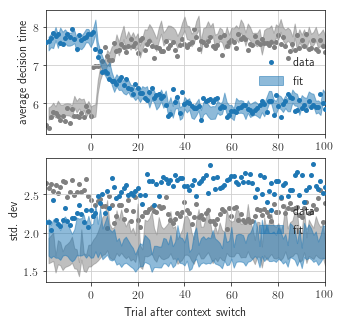

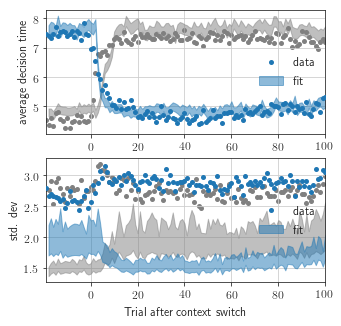

In [138]:
model_paras_S1_taus={'tau_context':338.226944,#/average_trial_duration,
            'sense_power':8.306030, 
            'tau_long':32623.003499,
            }
for subject in [1,2]:
    df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
    model_paras=model_paras_S1_taus if subject==1 else model_paras_S2_taus
    df_mod=get_model_output(df_act,model_paras,seed=10)
    plot_transitions({'act':df_act,'mod':df_mod})

Note that the block lengths differ for the two subjects and thus add to any inter subject varibability

No handles with labels found to put in legend.


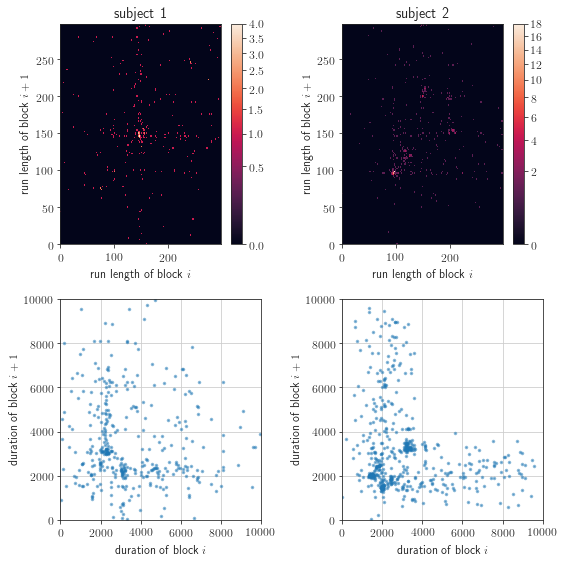

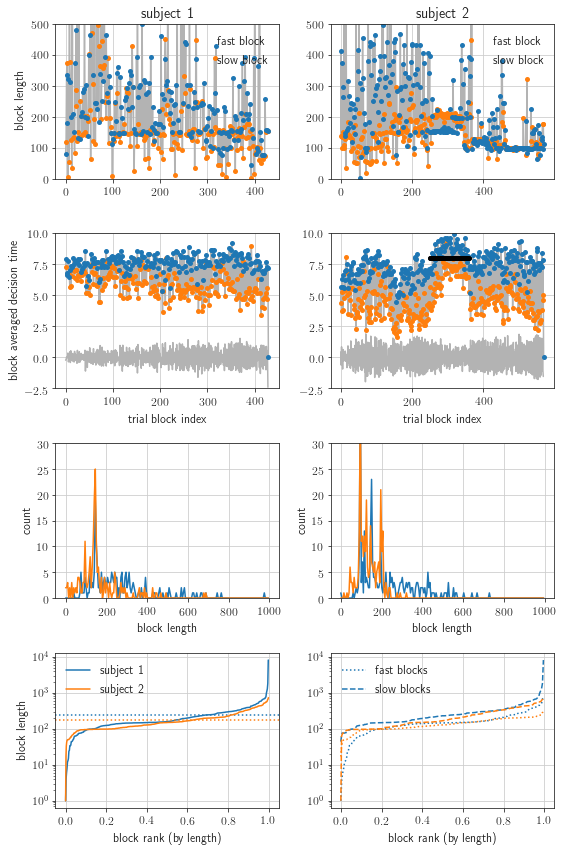

In [136]:
fig,ax=pl.subplots(2,2,figsize=(8,8))
figb,axb=pl.subplots(4,2,figsize=(8,12))
avg_blocksize=[]
import matplotlib.colors as mcolors
for sit, subject in enumerate(range(1,3)):
    df_tmp=df_data[df_data.idSubject==subject].reset_index(drop=True)
    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    cond=df_tmp['nPostInterval_diff']!=0   
    diffinds=np.diff(df_tmp[cond].index.values)
    h=ax[0,sit].hist2d(diffinds[1:], diffinds[:-1], bins=range(0,300,2),norm=mcolors.PowerNorm(0.5));
    ax[0,sit].set_title('subject '+str(subject))
    fig.colorbar(h[3],ax=ax[0,sit])
    ax[0,sit].set_xlabel('run length of block $i$')
    ax[0,sit].set_ylabel('run length of block $i+1$')
    axb[0,sit].set_ylim(0,500)
    axb[1,sit].set_xlabel('trial block index')
    axb[0,0].set_ylabel('block length')
   
    avg_blocksize.append(np.mean(diffinds))
#     ax2.plot(np.arange(len(diffinds))/len(diffinds),np.sort(diffinds),'.')
    
    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
    df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
    cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
    df_tmp['block_len']=0
    block_len_range=[-1,np.Inf]
    df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.

    inds=df_tmp[df_tmp.block_len!=0].index.values
    tStore=np.zeros(cond.sum())
    fast_ind=np.zeros(cond.sum(),dtype=bool)
    for it, ind in enumerate(inds[:-1]):
        late_Start=0
        if inds[it+1]-ind>late_Start:
            tStore[it]=df_tmp.iloc[ind+late_Start:inds[it+1]].tDecision.mean()
        fast_ind[it]=(df_tmp.iloc[ind].nPostInterval==50)
#     for it in range(0,len(inds[:-1]),10):
#         tStore[it:it+20]-=np.mean(tStore[it:it+20][~fast_ind[it:it+20]])-8
    axb[1,sit].plot(tStore,'-',color=[0.7]*3)
    axb[1,sit].plot(np.diff(tStore)/3,'-',color=[0.7]*3)
    axb[1,sit].plot(np.array(np.where(fast_ind))[0],tStore[fast_ind],'C1.')
    axb[1,sit].plot(np.array(np.where(~fast_ind))[0],tStore[~fast_ind],'C0.')
    axb[1,sit].set_ylim(-2.5,10)
    axb[1,0].set_ylabel('block averaged decision time')
    axb[1,1].plot([250,360],[8]*2,'k-',lw=5)

    axcum_ind=3
    tmp=df_tmp[cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
    p=axb[axcum_ind,0].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),label='subject '+str(subject))#lower bound on block size
    axb[axcum_ind,0].axhline(np.mean(tmp),ls=':',color=p[-1].get_color())
    
    tmp=df_tmp[cond & (df_tmp['block_len']>=0)].reset_index(drop=True)
    axb[0,sit].plot(tmp.block_len.values,'-',color=[0.7]*3)
    axb[0,sit].plot(tmp[(tmp.nPostInterval==50)].block_len,'C1.',label='fast block')
    axb[0,sit].plot(tmp[(tmp.nPostInterval==150)].block_len,'C0.',label='slow block')
    
    axhist_ind=2
    counts,bins=np.histogram(tmp[(tmp.nPostInterval==150)].block_len,bins=np.linspace(0,1000,200))
    axb[axhist_ind,sit].plot(bins[:-1],counts,'C0-')
    counts,bins=np.histogram(tmp[(tmp.nPostInterval==50)].block_len,bins=np.linspace(0,1000,200))
    axb[axhist_ind,sit].plot(bins[:-1],counts,'C1-')
    axb[axhist_ind,sit].set_ylim(0,30)
    axb[axhist_ind,sit].set_xlabel('block length')
    axb[axhist_ind,sit].set_ylabel('count')
    
    tmp=df_tmp[(df_tmp.nPostInterval==50) & cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
    axb[axcum_ind,1].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),'C'+str(sit)+':',label='fast blocks')#lower bound on block size
    
    tmp=df_tmp[(df_tmp.nPostInterval==150) & cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
    axb[axcum_ind,1].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),'C'+str(sit)+'--',label='slow blocks')#lower bound on block size
    
    if sit==0:
        axb[axcum_ind,1].legend(frameon=False)
#     ax2.set_ylim(50,500)
    axb[axcum_ind,1].set_yscale('log')
    axb[axcum_ind,0].set_yscale('log')
axb[0,0].legend(frameon=False)
axb[0,0].set_title('subject 1')
axb[0,1].set_title('subject 2')
axb[0,1].legend(frameon=False)
axb[axcum_ind,0].legend(frameon=False)
axb[axcum_ind,0].set_ylabel('block length')
axb[axcum_ind,0].set_ylabel('block length')
axb[axcum_ind,0].set_xlabel('block rank (by length)')
axb[axcum_ind,1].set_xlabel('block rank (by length)')
fig.tight_layout()

#now do durations
for sit, subject in enumerate(range(1,3)):
    df_tmp=df_data[df_data.idSubject==subject].reset_index(drop=True)
    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    cond=df_tmp['nPostInterval_diff']!=0
    #sum durations between 
    inds=df_tmp[cond].index.values
    diffinds=[]
    for it,ind in enumerate(inds[:-1]):
        diffinds.append(df_tmp.iloc[ind:inds[it+1]].duration.sum())
#     diffinds=np.diff(df_tmp[cond].index.values)
    diffinds=np.array(diffinds)
    h=ax[1,sit].plot(diffinds[1:], diffinds[:-1],'.',ms=3.0,alpha=0.5);
#     ax[1,sit].set_title('subject '+str(subject))
#     fig.colorbar(h[3],ax=ax[0,sit])
    ax[1,sit].set_xlabel('duration of block $i$')
    ax[1,sit].set_ylabel('duration of block $i+1$')
    ax[1,sit].set_xlim(0,10000)
    ax[1,sit].set_ylim(0,10000)
    avg_blocksize.append(np.mean(diffinds))
#     ax2.plot(np.arange(len(diffinds))/len(diffinds),np.sort(diffinds),'.')
    
#     df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
#     df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
#     cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
#     df_tmp['block_len']=0
#     block_len_range=[-1,np.Inf]
#     df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.
    
#     tmp=df_tmp[cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
#     p=ax[1,0].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),label='subject '+str(subject))#lower bound on block size
#     ax[1,0].axhline(np.mean(tmp),ls=':',color=p[-1].get_color())
#     tmp=df_tmp[(df_tmp.nPostInterval==50) & cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
#     ax[1,1].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),'C'+str(sit)+':',label='fast blocks')#lower bound on block size
    
#     tmp=df_tmp[(df_tmp.nPostInterval==150) & cond & (df_tmp['block_len']>=block_len_range[0]) & (df_tmp['block_len']<=block_len_range[1])].block_len.values
#     ax[1,1].plot(np.arange(len(tmp))/len(tmp),np.sort(tmp),'C'+str(sit)+'--',label='slow blocks')#lower bound on block size
#     if sit==0:
#         ax[1,1].legend(frameon=False)
# #     ax2.set_ylim(50,500)
#     ax[1,1].set_yscale('log')
#     ax[1,0].set_yscale('log')
ax[0,0].legend(frameon=False)
fig.tight_layout()
figb.tight_layout()
# figb.savefig('block_stats.png', transparent=True,bbox_inches='tight',dpi=300)
# fig.savefig('block_return_stats.png', transparent=True,bbox_inches='tight',dpi=300)


In [110]:
def move_axes(ax, fig, subplot_spec=111):
      """Move an Axes object from a figure to a new pyplot managed Figure in
      the specified subplot."""

      # get a reference to the old figure context so we can release it
      old_fig = ax.figure

      # remove the Axes from it's original Figure context
      ax.remove()

      # set the pointer from the Axes to the new figure
      ax.figure = fig

      # add the Axes to the registry of axes for the figure
      fig.axes.append(ax)
      # twice, I don't know why...
      fig.add_axes(ax)

      # then to actually show the Axes in the new figure we have to make
      # a subplot with the positions etc for the Axes to go, so make a
      # subplot which will have a dummy Axes
      dummy_ax = fig.add_subplot(subplot_spec)

      # then copy the relevant data from the dummy to the ax
      ax.set_position(dummy_ax.get_position())

      # then remove the dummy
      dummy_ax.remove()

      # close the figure the original axis was bound to
      pl.close(old_fig)

../lib/utils/ipynb_setup.py:16: RuntimeWarning: divide by zero encountered in true_divide
  pl.rc('lines',markeredgewidth = 2)


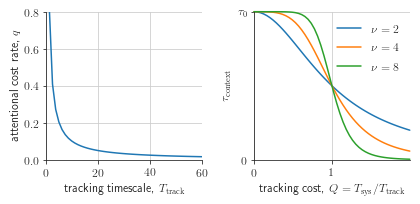

In [145]:
# df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
    
# model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
#             'sense_power':8.839935, 
#             'tau_long':31620.805644,
#             'Tcontext_bias':0,
#             'shared_noise_variance_factor':0,
#             'tau_shared_noise':30,
#             'context_noise_bias':0,
#             'context_noise_variance_factor':0
#             }
# df_mod=get_model_output(df_act,model_paras_S1_taus)
fig,axb=pl.subplots(1,2,figsize=(6,3))
# plot_transitions({'act':df_act,'mod':df_mod},ax=axb[2])
timevec=np.linspace(0,60)
axb[0].plot(timevec,1/timevec)
axb[0].set_xlim(0,60)
axb[0].set_ylim(0,0.8)
axb[0].set_ylabel('attentional cost rate, $q$')
axb[0].set_xlabel(r'tracking timescale, $T_\textrm{track}$')
axb[0].spines['right'].set_visible(False)
axb[0].spines['top'].set_visible(False)
for nu in [2,4,8]:
    axb[1].plot(timevec/30,1/(1+np.power(timevec/30,nu)),clip_on=False,label=r'$\nu='+str(nu)+r'$')
axb[1].set_xlabel(r'tracking cost, $Q=T_\textrm{sys}/T_\textrm{track}$')
axb[1].set_ylabel(r'$\tau_\textrm{context}$')
axb[1].set_yticks([0,1])
axb[1].set_yticklabels([r'$0$',r'$\tau_0$'])
axb[1].set_xticks([0,1])
axb[1].set_xticklabels([r'$0$',r'$1$'])
axb[1].set_xlim(0,2)
axb[1].set_ylim(0,1)
axb[1].spines['right'].set_visible(False)
axb[1].spines['top'].set_visible(False)
axb[1].legend(frameon=False)
# axb[0].axis('off')
# fig2=pl.figure()
# fig2.axes.append(axb[0,:])
# 2,axb2=pl.subplots(1,3,figsize=(8,3))
# axb2=
# move_axes(axb[0,:],fig2)
fig.tight_layout()
fig.savefig('sense_model.pdf', transparent=True,bbox_inches='tight',dpi=300)


evolution of policies

In [ ]:
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
plot_policies({'act':df_act,'mod':df_mod},file_name='all_times')
# plot_policies({'act':df_act.iloc[:20000],'mod':df_act.iloc[-20000:]},file_name='early_late')

## run context agnostic model

In [ ]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
# root_filename='v9_opt_neldermead_finejusttaus_1_1000'
# root_filename='v10_opt_neldermead_select'
# filename='v11_opt_neldermead_std'
# filename='v12_opt_neldermead_justmean'
filename='v13_opt_neldermead_justrholong'

root='../../output/data/'
run_evaluation('opt',1,df_data,root,filename,model_type='tau_only')

In [ ]:
average_trial_duration=get_trial_duration(6.5,0.5)
paravec=np.power(2,np.arange(11))*average_trial_duration
paras=[paravec[4],5,paravec[5]]
model_paras_S1_taus={'tau_context':12*average_trial_duration,  
                'tau_context_plus':30*average_trial_duration, 
                'tau_long':4363.40332031,#1000*average_trial_duration,
                'Tcontext_bias':2,
                'sense_power':8.839935, 
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=1)



plot_transitions({'act':df_act,'mod':df_mod})
plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

In [ ]:
(df_mod.nChoiceMade==df_mod.nCorrectChoice).sum()/df_mod.duration.sum()

In [ ]:
(df_act.nChoiceMade==df_act.nCorrectChoice).sum()/df_act.duration.sum()

In [ ]:
trial_bias=(df_act.nCorrectChoice==1).sum()/len(df_act)
response_bias=(df_act.nChoiceMade==1).sum()/len(df_act)
trial_bias_variance=trial_bias/np.sqrt(len(df_act))
print('response bias '+str(response_bias)+'\nis within std '+str(trial_bias_variance)+'\nof trial bias '+str(trial_bias))

## run model

In [ ]:
average_trial_duration=get_trial_duration(6.5,0.5)
paravec=np.power(2,np.arange(11))*average_trial_duration
paras=[paravec[4],5,paravec[5]]
model_paras_S1_taus={'tau_context':12*average_trial_duration,  
                'tau_context_plus':30*average_trial_duration, 
                'tau_long':20000,#1000*average_trial_duration,
                'Tcontext_bias':2,
                'sense_power':8.839935, 
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=1)

plot_transitions({'act':df_act,'mod':df_mod})

In [ ]:
# opt_paras=np.load('opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
                'sense_power':8.839935, 
                'tau_long':31620.805644,
                'Tcontext_bias':0,
                'shared_noise_variance_factor':0,
                'tau_shared_noise':30,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)

df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)

# df_mod.sensitivity_factor.hist()
# plot_transitions({'act':df_act,'mod':df_mod})

fig,ax=pl.subplots(1,2,figsize=(8,4))
# ax.plot(df_act.rho_context,df_mod.rho_context)
it=int(5e4)
ax[0].plot(df_mod.rho_context[:it+1],color='C0')
ax[0].plot([it],[df_mod.rho_context[it]],'o',color='C0')
ax[0].plot(df_mod.rho_long[:it+1],color='C1')
ax[0].plot([it],[df_mod.rho_long[it]],'o',color='C1')
ax[0].set_xlabel('trial')
ax[0].set_ylabel('filtered reward rate')
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.95*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{short}$}',color='C0',fontsize=14)
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.85*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{long}$}',color='C1',fontsize=14)
ax[0].set_xlim(0,it*(1.2))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
mean_rho_context=[]
block_trials=[]
binvec=np.linspace(0.037,0.053,100)
for bit,b in enumerate(block_times):
    dftmp=df_mod[(df_mod.nPostInterval==b)]
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
    ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'C0:')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],len(dftmp)/len(df_mod)*counts,'k--')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
    block_trials.append(len(dftmp))
counts,bins=np.histogram(df_mod.rho_context.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,'C0-')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
counts,bins=np.histogram(df_mod.rho_long.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,color='C1')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
mean_rho_long=(df_mod.nCorrectChoice==df_mod.nChoiceMade).sum()/df_mod.duration.sum()
ax[0].plot(ax[0].get_xlim(),[mean_rho_long]*2,'C1:')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'filtered reward rate, $\nu_t$')
ax[1].set_xlabel(r'filtered reward rate, $\nu_t$')
ax[1].set_ylabel('log density')
# ax[1].set_yscale('log')
# ax[1].set_ylim([1e0,10**(3.5)])
# ax[0].plot(ax[0].get_xlim(),[rhovec[0]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhovec[1]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhoavg]*2,'k--')
# ax[0].set_ylim(0.04,0.06)
# ax[0].set_xlim(0,100000)
# ax[1].set_xticks([rhovec[0],rhoavg,rhovec[1]])
# ax[1].set_xticklabels([r'$\rho_{\textrm{slow}}$',r'$\bar{\rho}$',r'$\rho_{\textrm{fast}}$'])
ax[1].set_yticks([])
ax[1].plot([mean_rho_context[0]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_context[1]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_long]*2,ax[1].get_ylim(),'C1:')
# ax[0].ticklabel_format(axis='x',style='sci',scilimits=(4,4))
# ax[0].set_ticklabels([]
ax[1].legend(frameon=False,prop={'size': 18},title=r'$\tau$')

# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', colorsre, len(colorsre))
# # define the bins and normalize
# bounds = np.append(np.log10(zetavec).astype('int'),np.log10(zetavec[-1])+1)-0.5
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# # create a second axes for the colorbar
# ax2 = fig.add_axes([1.02, 0.3, 0.02, 0.6])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds,boundaries=bounds, format='%1i')
# ax2.set_yticks(np.arange(2,int(np.log10(steps)))+1)
# ax2.set_yticklabels([r'$10^{'+str(int(b))+'}$' for b in (bounds[:-1]+1)])

for bit,b in enumerate(block_times):
    dftmp=df_act.copy()
    dftmp=dftmp[dftmp.nPostInterval==b]
    dftmp=get_model_output(dftmp,model_paras_S1_taus,seed=10)
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
#     ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'k--')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],block_trials[bit]/(2*len(dftmp))*counts,'k:')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')

target=(df_mod.nCorrectChoice==df_mod.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_mod.duration.sum()]*2,'k--')
target=(df_act.nCorrectChoice==df_act.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_act.duration.sum()]*2,'k--')


fig.tight_layout()
# fig.savefig('filtered_rew.pdf', transparent=True,bbox_inches='tight',dpi=300)
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='rho_context')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='trialRR')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='T_context')
fig,ax=pl.subplots(2,1,figsize=(4,8))
ax=plot_transitions({'act':df_act,'mod':df_mod},ax=ax,measure='tDecision')#trialRR')
fig.savefig('transition.png', transparent=True,bbox_inches='tight',dpi=300)
# plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

fig,ax=pl.subplots(1,1,figsize=(4,4))
df_tmp=df_mod
df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
cond=df_tmp['nPostInterval_diff']!=0
df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff(periods=1) #dx_i=x_i-x_i-1
df_tmp.loc[0,'nPostInterval_diff']=0 #replace nan ###remove initial block (an outlier in length)
cond=df_tmp['nPostInterval_diff']!=0 #location of trial type switch,i.e. block start
df_tmp['block_len']=0
block_len_range=[-1,np.Inf]
df_tmp.loc[cond,'block_len']=np.diff(np.insert(df_tmp[cond].index.values,cond.sum(),len(df_tmp))) #tag block starts with corresponding block length.np.diff uses period=-1 so add last block.

inds=df_tmp[df_tmp.block_len!=0].index.values
tStore=np.zeros(cond.sum())
fast_ind=np.zeros(cond.sum(),dtype=bool)
for it, ind in enumerate(inds[:-1]):
    late_Start=0
    if inds[it+1]-ind>late_Start:
        tStore[it]=df_tmp.iloc[ind+late_Start:inds[it+1]].tDecision.mean()
    fast_ind[it]=(df_tmp.iloc[ind].nPostInterval==50)
ax.plot(tStore,'-',color=[0.7]*3)
ax.plot(np.array(np.where(fast_ind))[0],tStore[fast_ind],'C0.')
ax.plot(np.array(np.where(~fast_ind))[0],tStore[~fast_ind],'C1.')
ax.set_ylim(0,12)

model's deviation in trial switch variance actual improves performance

In [ ]:
model_RR=(df_mod.nChoiceMade==df_mod.nCorrectChoice).sum()/df_mod.duration.sum()
subject1_RR=(df_act.nChoiceMade==df_act.nCorrectChoice).sum()/df_act.duration.sum()
print('model RR   :'+str(model_RR)+'\nsubject1 RR:'+str(subject1_RR))

Figure out transition varianc ebehaviour

In [ ]:
fig,ax=pl.subplots()
ax.plot(df_mod[df_mod.nPostInterval==50].T_context.values,df_mod[df_mod.nPostInterval==50].rho_context.values,'.',alpha=0.01)
ax.plot(df_mod[df_mod.nPostInterval==150].T_context.values,df_mod[df_mod.nPostInterval==150].rho_context.values,'.',alpha=0.01)
print(df_mod[df_mod.nPostInterval==50].T_context.std())
print(df_mod[df_mod.nPostInterval==150].T_context.std())
ax.plot(df_mod[df_mod.nPostInterval==50].duration.values,df_mod[df_mod.nPostInterval==50].rho_context.values,'.',alpha=0.01)
ax.plot(df_mod[df_mod.nPostInterval==150].duration.values,df_mod[df_mod.nPostInterval==150].rho_context.values,'.',alpha=0.01)
print(df_mod[df_mod.nPostInterval==50].duration.std())
print(df_mod[df_mod.nPostInterval==150].duration.std())
fig,ax=pl.subplots(1,1)
# ax[0].hist2d(df_mod[df_mod.nPostInterval==50].tDecision.values,df_act[df_act.nPostInterval==50].tDecision.values,bins=np.arange(17))
# ax[1].hist2d(df_mod[df_mod.nPostInterval==150].tDecision.values,df_act[df_act.nPostInterval==150].tDecision.values,bins=np.arange(17))

# ax.plot(df_mod[df_mod.nPostInterval==50].tDecision.values,df_act[df_act.nPostInterval==50].rho_context.values,'.',alpha=0.01)
# ax.plot(df_mod[df_mod.nPostInterval==150].tDecision.values,df_act[df_act.nPostInterval==150].rho_context.values,'.',alpha=0.01)
# print(df_mod[df_mod.nPostInterval==50].tDecision.std())
# print(df_mod[df_mod.nPostInterval==150].tDecision.std())
ax.plot(df_mod[df_mod.nPostInterval==50].tDecision.values,df_mod[df_mod.nPostInterval==50].rho_context.values,'.',alpha=0.01)
ax.plot(df_mod[df_mod.nPostInterval==150].tDecision.values,df_mod[df_mod.nPostInterval==150].rho_context.values,'.',alpha=0.01)
print(df_mod[df_mod.nPostInterval==50].tDecision.std())
print(df_mod[df_mod.nPostInterval==150].tDecision.std())
fig,ax=pl.subplots(2,1)
df_mod.groupby('nPostInterval').tDecision.hist(ax=ax[0],bins=np.arange(17),alpha=0.5)
df_act.groupby('nPostInterval').tDecision.hist(ax=ax[1],bins=np.arange(17),alpha=0.5)

try constant rho long model

In [ ]:
fig,ax=pl.subplots(2,1,figsize=(4,8))
ax=plot_transitions({'act':df_act,'mod':df_mod},ax=ax)

In [ ]:
# opt_paras=np.load('opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
model_paras_S1_taus={'tau_context':344.542274,#407.047901,  
                'sense_power':8.626876,##8.839935, 
                'tau_long':34275.948232,#31620.805644,
                'Tcontext_bias':0,
                'shared_noise_variance_factor':0.01,#0.4,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0.05#0.4
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)

df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)

# df_mod.sensitivity_factor.hist()
# plot_transitions({'act':df_act,'mod':df_mod})

fig,ax=pl.subplots(1,2,figsize=(8,4))
# ax.plot(df_act.rho_context,df_mod.rho_context)
it=int(5e4)
ax[0].plot(df_mod.rho_context[:it+1],color='C0')
ax[0].plot([it],[df_mod.rho_context[it]],'o',color='C0')
ax[0].plot(df_mod.rho_long[:it+1],color='C1')
ax[0].plot([it],[df_mod.rho_long[it]],'o',color='C1')
ax[0].set_xlabel('trial')
ax[0].set_ylabel('filtered reward rate')
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.95*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{short}$}',color='C0',fontsize=14)
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.85*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{long}$}',color='C1',fontsize=14)
ax[0].set_xlim(0,it*(1.2))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
mean_rho_context=[]
block_trials=[]
binvec=np.linspace(0.037,0.053,100)
for bit,b in enumerate(block_times):
    dftmp=df_mod[(df_mod.nPostInterval==b)]
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
    ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'C0:')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],len(dftmp)/len(df_mod)*counts,'k--')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
    block_trials.append(len(dftmp))
counts,bins=np.histogram(df_mod.rho_context.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,'C0-')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
counts,bins=np.histogram(df_mod.rho_long.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,color='C1')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
mean_rho_long=(df_mod.nCorrectChoice==df_mod.nChoiceMade).sum()/df_mod.duration.sum()
ax[0].plot(ax[0].get_xlim(),[mean_rho_long]*2,'C1:')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'filtered reward rate, $\nu_t$')
ax[1].set_xlabel(r'filtered reward rate, $\nu_t$')
ax[1].set_ylabel('log density')
# ax[1].set_yscale('log')
# ax[1].set_ylim([1e0,10**(3.5)])
# ax[0].plot(ax[0].get_xlim(),[rhovec[0]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhovec[1]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhoavg]*2,'k--')
# ax[0].set_ylim(0.04,0.06)
# ax[0].set_xlim(0,100000)
# ax[1].set_xticks([rhovec[0],rhoavg,rhovec[1]])
# ax[1].set_xticklabels([r'$\rho_{\textrm{slow}}$',r'$\bar{\rho}$',r'$\rho_{\textrm{fast}}$'])
ax[1].set_yticks([])
ax[1].plot([mean_rho_context[0]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_context[1]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_long]*2,ax[1].get_ylim(),'C1:')
# ax[0].ticklabel_format(axis='x',style='sci',scilimits=(4,4))
# ax[0].set_ticklabels([]
ax[1].legend(frameon=False,prop={'size': 18},title=r'$\tau$')

# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', colorsre, len(colorsre))
# # define the bins and normalize
# bounds = np.append(np.log10(zetavec).astype('int'),np.log10(zetavec[-1])+1)-0.5
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# # create a second axes for the colorbar
# ax2 = fig.add_axes([1.02, 0.3, 0.02, 0.6])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds,boundaries=bounds, format='%1i')
# ax2.set_yticks(np.arange(2,int(np.log10(steps)))+1)
# ax2.set_yticklabels([r'$10^{'+str(int(b))+'}$' for b in (bounds[:-1]+1)])

for bit,b in enumerate(block_times):
    dftmp=df_act.copy()
    dftmp=dftmp[dftmp.nPostInterval==b]
    dftmp=get_model_output(dftmp,model_paras_S1_taus,seed=10)
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
#     ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'k--')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],block_trials[bit]/(2*len(dftmp))*counts,'k:')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')

target=(df_mod.nCorrectChoice==df_mod.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_mod.duration.sum()]*2,'k--')
target=(df_act.nCorrectChoice==df_act.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_act.duration.sum()]*2,'k--')


fig.tight_layout()
fig.savefig('filtered_rew.pdf', transparent=True,bbox_inches='tight',dpi=300)
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='rho_context')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='trialRR')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='T_context')
fig,ax=pl.subplots(1,2,figsize=(4,4))
ax=plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
fig.savefig('transition.png', transparent=True,bbox_inches='tight',dpi=300)

fig,ax=pl.subplots(2,1)
df_mod.groupby('nPostInterval').tDecision.hist(ax=ax[0],bins=np.arange(17),alpha=0.5)
df_act.groupby('nPostInterval').tDecision.hist(ax=ax[1],bins=np.arange(17),alpha=0.5)

In [ ]:
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
timevec,data_store_actual=get_transition_ensemble(df_act)

#select objective
part_error_fn=partial(get_error,df_act=df_act,data_store_actual=data_store_actual,model='taus_only')
para_init=np.array([600,20000,15])
part_error_fn(para_init)

In [ ]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
# root_filename='v9_opt_neldermead_finejusttaus_1_1000'
# root_filename='v10_opt_neldermead_select'
filename='v11_opt_neldermead_std'
filename='v12_opt_neldermead_justmean'

root='../../output/data/'
run_evaluation('opt',1,df_data,root,filename,model_type='tau_only')

In [ ]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
# root_filename='v9_opt_neldermead_finejusttaus_1_1000'
root_filename='v10_opt_neldermead_select'

run_evaluation('opt',1,df_data,root_filename,model_type='tau_only')

In [ ]:
plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

single context

In [ ]:
dftmp=df_act.copy()
dftmp.nPostInterval=50
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)
df_mod

## Optimize on only slow to fast transitions

In [136]:
root_filename='v12uniconv_opt_neldermead_justfastslowmodel_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

Iter      tauc      taul      unitconv  
1 315.000000 10500.000000 0.900000 
2 320.000000 9833.333333 0.933333 
3 320.000000 9833.333333 0.933333 
4 320.000000 9833.333333 0.933333 
5 320.833333 10138.888889 0.930556 
6 320.833333 10138.888889 0.930556 
7 318.634259 10277.006173 0.911497 
8 322.897377 10136.445473 0.915111 
9 322.897377 10136.445473 0.915111 
10 322.897377 10136.445473 0.915111 
11 319.988658 10185.999062 0.916646 
12 319.988658 10185.999062 0.916646 
13 319.988658 10185.999062 0.916646 
14 319.988658 10185.999062 0.916646 
15 319.988658 10185.999062 0.916646 
16 319.988658 10185.999062 0.916646 
17 319.988658 10185.999062 0.916646 
18 319.988658 10185.999062 0.916646 
19 319.988658 10185.999062 0.916646 
20 319.988658 10185.999062 0.916646 
21 319.775662 10159.283937 0.918559 
22 319.775662 10159.283937 0.918559 
23 319.775662 10159.283937 0.918559 
24 319.775662 10159.283937 0.918559 
25 319.775662 10159.283937 0.918559 
26 319.775662 10159.283937 0.918559 
27 319.45

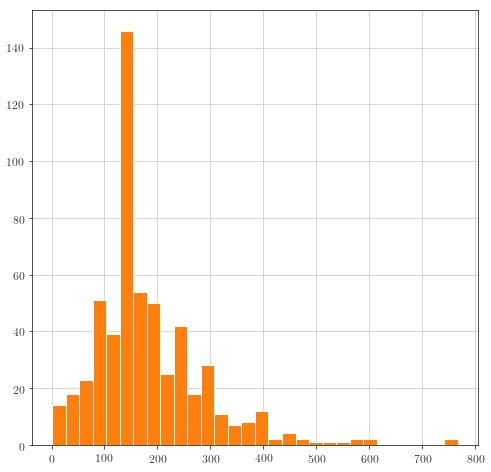

In [248]:
df_tmp=df_data[df_data.idSubject==1].reset_index(drop=True)
time_depth=100
history=20
timevec=np.arange(-history,time_depth)
data_store=[]
block_times=[150,50]
measure='tDecision'
for b in block_times:
    block_lens=df_tmp.block_idx.value_counts().sort_index()
    pl.hist(block_lens,bins=30)
    inds=(df_tmp[df_tmp.nPostInterval==b].block_idx.diff(periods=1)>0).index.values
    data=np.empty((df_tmp.block_idx.iloc[-1],len(timevec))) #maximum possible
    data[:]=np.nan
    startinds=df_tmp.reset_index().groupby('block_idx').first()['index'].values[:-1]
    for idx,start_idx in enumerate(startinds):
        if idx>0:
            duration=min([block_lens[idx],time_depth])
            data[idx-1,:history+duration]=df_tmp.iloc[start_idx-history:start_idx+duration][measure].values
    data_store.append(data)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


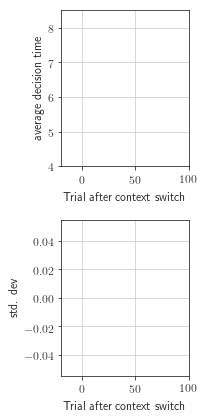

In [252]:
model_paras_S1_taus={'tau_context':320,#679,#/average_trial_duration,
            'tau_long':10178,#11741,
            'unitconv':0.9189,
                     
            }

fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
model_paras=model_paras_S1_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
# fig.savefig('model_fitting_justslow_s1.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [140]:
root_filename='v12uniconv_opt_neldermead_justfastslowmodel_subject2'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

Iter      tauc      taul      unitconv  
1 300.000000 10000.000000 1.050000 
2 285.000000 10833.333333 1.083333 
3 270.000000 10166.666667 1.166667 
4 270.000000 10166.666667 1.166667 
5 270.000000 10166.666667 1.166667 
6 270.000000 10166.666667 1.166667 
7 270.000000 10166.666667 1.166667 
8 270.000000 10166.666667 1.166667 
9 270.000000 9833.333333 1.172222 
10 262.777778 9993.827160 1.159877 
11 262.777778 9993.827160 1.159877 
12 254.907407 9765.946502 1.192078 
13 239.814815 10365.226337 1.200823 
14 233.240741 9580.761317 1.166152 
15 233.240741 9580.761317 1.166152 
16 185.771605 10228.223594 1.195645 
17 161.913580 8892.661180 1.172977 
18 135.864198 9073.388203 1.109122 
19 89.125514 9215.420668 1.152343 
20 89.125514 9215.420668 1.152343 
21 89.125514 9215.420668 1.152343 
22 77.953818 8422.356856 1.141467 
23 105.115074 8660.051398 1.137497 
24 81.447696 8329.349707 1.118876 
25 81.447696 8329.349707 1.118876 
26 81.447696 8329.349707 1.118876 
27 81.447696 8329.349707 1.11

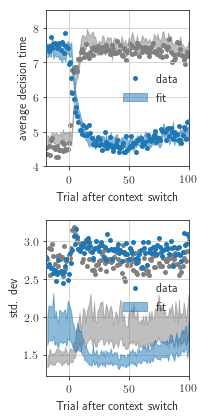

In [143]:
model_paras_S2_taus={'tau_context':87,#679,#/average_trial_duration,
            'tau_long':8488,#11741,
            'unitconv':1.129
            }

fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
model_paras=model_paras_S2_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
# fig.savefig('model_fitting_justslow_s1.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [299]:
root_filename='v12uniconv_opt_neldermead_both_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='default')

Iter      tauc      taul      unitconv  sensepow  
1 694.464372 40068.753134 1.046686 15.617132 
2 723.762088 39770.622530 1.066311 14.128624 
3 723.762088 39770.622530 1.066311 14.128624 
4 723.762088 39770.622530 1.066311 14.128624 
5 723.762088 39770.622530 1.066311 14.128624 
6 700.351890 39833.276540 1.065621 14.205356 
7 700.351890 39833.276540 1.065621 14.205356 
8 764.299178 41436.339935 1.045731 12.195034 
9 764.299178 41436.339935 1.045731 12.195034 
10 710.001812 43090.356114 1.042640 12.027252 
11 710.001812 43090.356114 1.042640 12.027252 
12 710.001812 43090.356114 1.042640 12.027252 
13 710.001812 43090.356114 1.042640 12.027252 
14 710.001812 43090.356114 1.042640 12.027252 
15 710.001812 43090.356114 1.042640 12.027252 
16 710.001812 43090.356114 1.042640 12.027252 
17 690.590611 44031.374864 1.046859 11.948461 
18 690.590611 44031.374864 1.046859 11.948461 
19 690.590611 44031.374864 1.046859 11.948461 
20 690.590611 44031.374864 1.046859 11.948461 
21 667.453533 4469

TypeError: 'AxesSubplot' object is not subscriptable

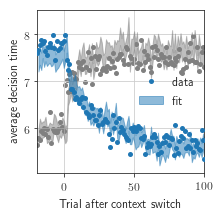

In [129]:
model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
#686.189010 37544.306042 1.051416 16.060446
fig,ax=pl.subplots(1,1,figsize=(3,3))
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
model_paras=model_paras_S1_taus
df_mod=get_model_output(df_act,model_paras)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
# ax.set_ylim(4,8.5)
fig.tight_layout()
# fig.savefig('model_fitting_asym_4para_s1.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [53]:
for subject in [1,2]:
    for plane_idx in range(1,3):
        if subject==1 and plane_idx==1:
            print('skip')
        else:
            root_filename='v14uniconv_opt_neldermead_both_subject'+str(subject)+'_p'+str(plane_idx)
            root_dir='../../output/data/'
            run_evaluation('grid',subject,df_data,root_dir,root_filename,model_type='default',plane_idx=plane_idx)

skip
1 of 20 took 4.427707672119141
2 of 20 took 89.92406916618347
3 of 20 took 90.61035466194153
4 of 20 took 90.40929532051086
5 of 20 took 91.0060932636261
6 of 20 took 90.71142792701721
7 of 20 took 92.10110068321228
8 of 20 took 92.26860928535461
9 of 20 took 92.95907855033875
10 of 20 took 92.91409516334534
11 of 20 took 93.66905188560486
12 of 20 took 93.91682195663452
13 of 20 took 93.48732423782349
14 of 20 took 94.33917021751404
15 of 20 took 93.86653089523315
16 of 20 took 94.29023718833923
17 of 20 took 94.40410017967224
18 of 20 took 94.04171824455261
19 of 20 took 93.93203353881836
20 of 20 took 95.04576325416565
grid took 1858.2616205215454
1 of 20 took 5.024809122085571
2 of 20 took 99.80078268051147
3 of 20 took 100.94909620285034
4 of 20 took 99.86851119995117
5 of 20 took 100.28888726234436
6 of 20 took 100.99424767494202
7 of 20 took 100.849529504776
8 of 20 took 101.02897882461548
9 of 20 took 101.2141535282135
10 of 20 took 100.97207283973694
11 of 20 took 101.627

In [ ]:
test

In [443]:
root_filename='v15uniconv_opt_neldermead_both_subject2'
root_dir='../../output/data/'
run_evaluation(tau_short_it,'grid',2,df_data,root_dir,root_filename,model_type='default')

1 of 30 took 4.724738359451294
2 of 30 took 182.57773661613464
3 of 30 took 183.87780284881592
4 of 30 took 182.483971118927
5 of 30 took 180.32309865951538
6 of 30 took 174.1666443347931
7 of 30 took 173.06422638893127
8 of 30 took 165.66671872138977
9 of 30 took 160.37065887451172
10 of 30 took 155.09455513954163
11 of 30 took 153.12006878852844
12 of 30 took 149.8064877986908
13 of 30 took 143.94762206077576
14 of 30 took 141.19645500183105
15 of 30 took 137.9166066646576
16 of 30 took 133.34806203842163
17 of 30 took 133.86487793922424
18 of 30 took 123.16323018074036
19 of 30 took 119.01438641548157
20 of 30 took 112.36820864677429
21 of 30 took 106.03577756881714
22 of 30 took 106.0505096912384
23 of 30 took 103.22831344604492
24 of 30 took 96.38720870018005
25 of 30 took 91.0592679977417
26 of 30 took 87.36808109283447
27 of 30 took 81.27169895172119
28 of 30 took 78.02805399894714
29 of 30 took 72.35417819023132
30 of 30 took 67.64248132705688
grid took 3868.2555713653564


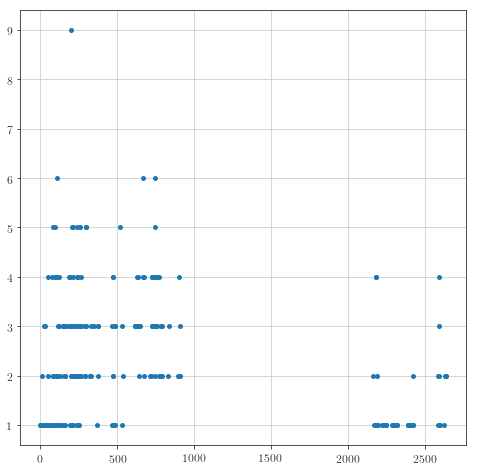

In [285]:
(df_data[df_data.idSubject==1].groupby('block_idx').first().dDate-df_data[df_data.idSubject==1].groupby('block_idx').first().dDate[0]).dt.days.value_counts().sort_index().plot(style='.')

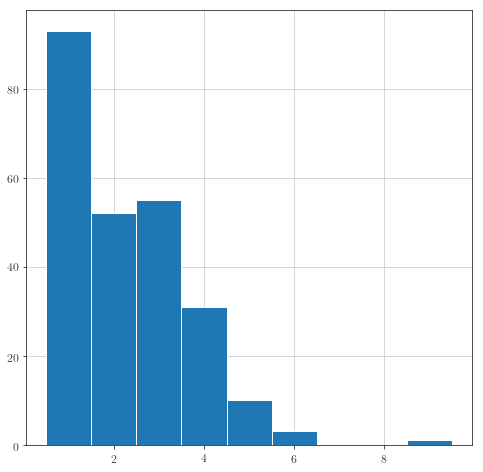

In [287]:
(df_data[df_data.idSubject==1].groupby('block_idx').first().dDate-df_data[df_data.idSubject==1].groupby('block_idx').first().dDate[0]).dt.days.value_counts().sort_index().hist(bins=np.arange(0.5,10.5))

In [289]:
block_day=(df_data[df_data.idSubject==1].groupby('block_idx').first().dDate-df_data[df_data.idSubject==1].groupby('block_idx').first().dDate[0]).dt.days

In [292]:
len(np.where(block_day.values[1:]==block_day.values[:-1])[0])

318

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

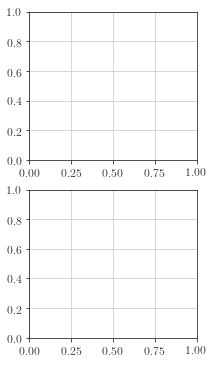

In [103]:
model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
#686.189010 37544.306042 1.051416 16.060446
fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
model_paras=model_paras_S1_taus
df_mod=get_model_output(df_act,model_paras)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
# fig.savefig('model_fitting_asym_4para_s1.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [301]:
root_filename='v12uniconv_opt_neldermead_both_subject2'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='default')

Iter      tauc      taul      unitconv  sensepow  
1 142.554012 43097.993800 1.207500 8.199383 
2 142.554012 43097.993800 1.207500 8.199383 
3 139.881124 45522.255951 1.214687 7.891906 
4 139.881124 45522.255951 1.214687 7.891906 
5 139.881124 45522.255951 1.214687 7.891906 
6 139.881124 45522.255951 1.214687 7.891906 
7 139.881124 45522.255951 1.214687 7.891906 
8 142.619703 45693.106458 1.221015 7.583979 
9 142.619703 45693.106458 1.221015 7.583979 
10 138.572006 45869.489219 1.207172 7.766233 
11 141.649658 46857.374895 1.205685 7.605859 
12 145.007527 46131.604467 1.202549 7.317814 
13 145.007527 46131.604467 1.202549 7.317814 
14 145.007527 46131.604467 1.202549 7.317814 
15 148.756003 49209.625974 1.198099 6.716518 
16 148.756003 49209.625974 1.198099 6.716518 
17 152.657614 49523.035649 1.203069 6.043209 
18 152.657614 49523.035649 1.203069 6.043209 
19 152.657614 49523.035649 1.203069 6.043209 
20 167.189285 53354.410106 1.181131 4.504600 
21 167.189285 53354.410106 1.181131 4.

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

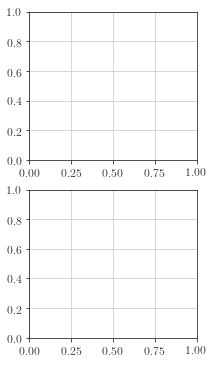

In [104]:
model_paras_S2_taus={'tau_context':188,
            'sense_power':2.308, 
            'tau_long':56605,
                     'unitconv':1.15
            }
#686.189010 37544.306042 1.051416 16.060446
fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
model_paras=model_paras_S2_taus
df_mod=get_model_output(df_act,model_paras)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
fig.savefig('model_fitting_asym_4para_s2.pdf', transparent=True,bbox_inches="tight",dpi=300)

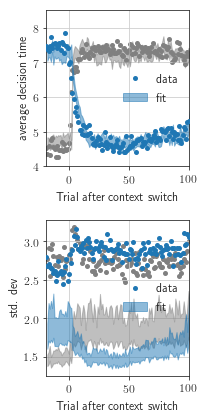

In [155]:
model_paras_S2_taus={'tau_context':188,
            'sense_power':2.308, 
            'tau_long':56605,
                     'unitconv':1.15
            }
#686.189010 37544.306042 1.051416 16.060446
fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
model_paras=model_paras_S2_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
fig.savefig('model_fitting_asym_4para_s2.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [146]:
root_filename='v12uniconv_opt_neldermead_both_subject2'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='default')

Iter      tauc      taul      unitconv  sensepow  
1 128.298611 44714.168567 1.037500 -8.506860 
2 135.426311 44983.531029 1.043750 -7.943152 
3 135.426311 44983.531029 1.043750 -7.943152 
4 135.426311 44983.531029 1.043750 -7.943152 
5 135.426311 44983.531029 1.043750 -7.943152 
6 135.426311 44983.531029 1.043750 -7.943152 
7 135.426311 44983.531029 1.043750 -7.943152 
8 131.007933 45296.128105 1.030294 -8.227054 
9 132.788608 44227.295179 1.035160 -8.222786 
10 137.889496 45597.491641 1.040063 -7.458951 
11 137.889496 45597.491641 1.040063 -7.458951 
12 137.889496 45597.491641 1.040063 -7.458951 
13 149.576570 43799.360017 1.036808 -6.965457 
14 149.576570 43799.360017 1.036808 -6.965457 
15 161.817199 44627.462189 1.054978 -5.944829 
16 165.869225 45333.618587 1.060992 -4.970649 
17 165.869225 45333.618587 1.060992 -4.970649 
18 165.869225 45333.618587 1.060992 -4.970649 
19 210.794991 45509.110434 1.105783 -1.359952 
20 210.794991 45509.110434 1.105783 -1.359952 
21 210.794991 4550

In [ ]:
root_filename='v11check_opt_neldermead_justfastslowmodel_subject2'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

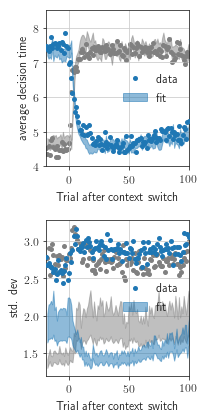

In [122]:
model_paras_S2_taus={'tau_context':53,#679,#/average_trial_duration,
#             'sense_power':20000, 
            'tau_long':13917#11741,
            }

fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
model_paras=model_paras_S2_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(4,8.5)
fig.tight_layout()
fig.savefig('model_fitting_justslow_s2.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [93]:
# root_filename='v10_opt_neldermead_justfastslowmodel_subject1'
root_filename='v11check_opt_neldermead_justfastslowmodel_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

Iter      tauc      taul      
0.20090391202451777
0.18107373354966647
0.20148674959437538
0.18046980349738598
0.1747602307553633
1 322.500000 9000.000000 
0.16251415179376238
0.14992103839913468
2 356.250000 8500.000000 
0.14602974580854516
0.12815269515053182
3 388.125000 6250.000000 
0.10637263385613845
0.0899060753560483
4 471.562500 4125.000000 
0.11488840814854875
5 471.562500 4125.000000 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:66: RuntimeWarning: overflow encountered in double_scalars
  return rho_long*trial_time_vec+(rho_context-rho_long)*T_context
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:66: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec+(rho_context-rho_long)*T_context
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:66: RuntimeWarning: invalid value encountered in add
  return rho_long*trial_time_vec+(rho_context-rho_long)*T_context
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:122: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:123: RuntimeWarning: invalid value encountered in less_equal
  t_decision=

52.42158265729222
0.10038633495583198
6 471.562500 4125.000000 
0.12028574003966105
0.0952190373174689
7 471.562500 4125.000000 
0.09911249323958896
0.09280548043987741
8 471.562500 4125.000000 
0.08782729403281055
0.08575788714620516
9 490.312500 4625.000000 
0.08934000360555253
10 490.312500 4625.000000 
0.08435136109608798
0.08480511988462232
11 486.562500 6125.000000 
0.07898593834505138
0.0777425635478637
12 529.687500 4875.000000 
0.07438615467820445
0.07420930232558139
13 543.750000 7250.000000 
0.06841445826572921
0.06863205336217776
14 586.875000 6000.000000 
0.06562592392284115
0.06341752298539748
15 636.562500 10125.000000 
0.06220930232558139
0.06513628988642507
16 679.687500 8875.000000 
0.06209410492157919
0.06227239949522261
17 729.375000 13000.000000 
0.06448945375878849
0.06073679466378222
18 670.546875 10531.250000 
0.061721471065440715
19 670.546875 10531.250000 
0.061636380025238864
20 670.546875 10531.250000 
0.06448729042725794
0.06086785649900844
21 670.546875 10

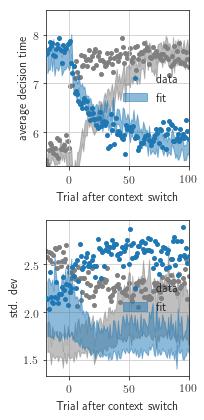

In [104]:
model_paras_S1_taus={'tau_context':679,#/average_trial_duration,
#             'sense_power':20000, 
            'tau_long':11741,
            }

fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
model_paras=model_paras_S1_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(5.3,8.5)
fig.tight_layout()
fig.savefig('model_fitting_justslow.pdf', transparent=True,bbox_inches="tight",dpi=300)

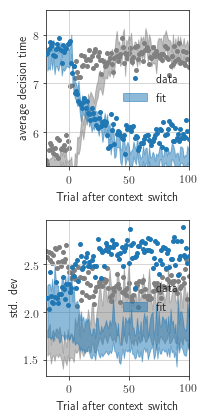

In [132]:
model_paras_S1_taus={'tau_context':379,#/average_trial_duration,
#             'sense_power':20000, 
            'tau_long':11741,
            }

fig,ax=pl.subplots(2,1,figsize=(3,6))
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
model_paras=model_paras_S1_taus
df_mod=get_model_output(df_act,model_paras,seed=10)
plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
ax[0].set_ylim(5.3,8.5)
fig.tight_layout()
# fig.savefig('model_fitting_justslow.pdf', transparent=True,bbox_inches="tight",dpi=300)


In [ ]:
# root_filename='v10_opt_neldermead_justfastslowmodel_subject1'
root_filename='v11check_opt_neldermead_justfastslowmodel_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

## optimize $(\tau_{long},\tau_{short})$-Model

In [113]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
# root_filename='v9_opt_neldermead_finejusttaus_1_1000'
# run_evaluation('opt',1,df_data,root_filename,model_type='tau_only')
root_filename='v10_opt_neldermead_defaultmodel_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='tau_only')

Iter      tauc      taul      sensepow  
1 630.000000 21000.000000 13.500000 
2 570.000000 22000.000000 13.500000 
3 600.000000 24000.000000 12.000000 
4 600.000000 25000.000000 9.000000 
5 510.000000 29000.000000 7.500000 
6 510.000000 29000.000000 7.500000 
7 510.000000 29000.000000 7.500000 
8 510.000000 29000.000000 7.500000 
9 510.000000 29000.000000 7.500000 
10 477.407407 29185.185185 8.919753 
11 477.407407 29185.185185 8.919753 
12 388.827160 32179.012346 7.511317 
13 388.827160 32179.012346 7.511317 
14 388.827160 32179.012346 7.511317 
15 388.827160 32179.012346 7.511317 
16 371.423563 31292.790733 8.586979 
17 322.812706 32684.943860 8.337599 
18 322.812706 32684.943860 8.337599 
19 322.812706 32684.943860 8.337599 
20 322.812706 32684.943860 8.337599 
21 322.812706 32684.943860 8.337599 
22 322.812706 32684.943860 8.337599 
23 339.498576 32576.838820 8.245978 
24 339.498576 32576.838820 8.245978 
25 339.498576 32576.838820 8.245978 
26 339.498576 32576.838820 8.245978 
27 

In [144]:
root_filename='v10_opt_neldermead_tausmodel_subject2_check'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='tau_only')

Iter      tauc      taul      sensepow  
1 142.554012 45252.893490 -8.199383 
2 142.554012 45252.893490 -8.199383 
3 140.376103 44355.018619 -8.256323 
4 140.376103 44355.018619 -8.256323 
5 140.376103 44355.018619 -8.256323 
6 140.995744 45974.518849 -8.333298 
7 140.995744 45974.518849 -8.333298 
8 140.995744 45974.518849 -8.333298 
9 140.995744 45974.518849 -8.333298 
10 140.995744 45974.518849 -8.333298 
11 140.842056 45903.298528 -8.270540 
12 140.385896 45811.256432 -8.317647 
13 140.385896 45811.256432 -8.317647 
14 140.385896 45811.256432 -8.317647 
15 140.385896 45811.256432 -8.317647 
16 140.385896 45811.256432 -8.317647 
17 140.684198 46083.329563 -8.300721 
18 140.684198 46083.329563 -8.300721 
19 140.684198 46083.329563 -8.300721 
20 140.566742 46020.234985 -8.312258 
21 140.566742 46020.234985 -8.312258 
22 140.566742 46020.234985 -8.312258 
23 140.566742 46020.234985 -8.312258 
24 140.566742 46020.234985 -8.312258 
25 140.574372 46024.874347 -8.311238 
26 140.574372 4602

In [ ]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import inset_locator

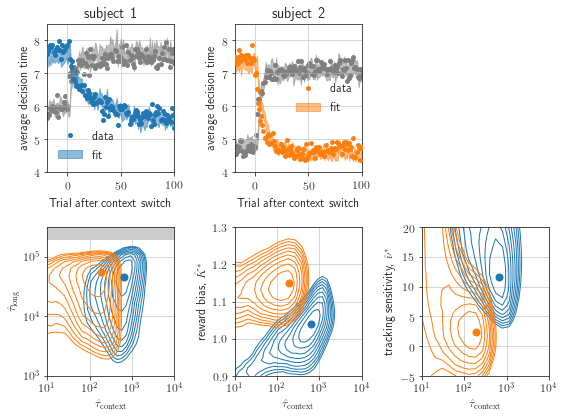

In [122]:
fig,ax=pl.subplots(2,3,figsize=(8,6))
average_trial_duration=22
avg_blocksize=100

model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
model_paras_S2_taus={'tau_context':188,
            'sense_power':2.308, 
            'tau_long':56605,
                     'unitconv':1.15
            }


for sit,model_paras in enumerate([model_paras_S1_taus,model_paras_S2_taus]):
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)    
    df_mod=get_model_output(df_act,model_paras)
    axtmp=plot_transitions({'act':df_act,'mod':df_mod},ax=ax[0,sit],col='C'+str(sit))
    axtmp.legend(frameon=False,loc=3 if sit==0 else 5)
    ax[0,sit].set_ylim(4,8.5)
#     axp=plot_transitions({'act':df_act,'mod':df_mod},ax=axs[sit])
#     axp.set_ylabel('average decision time')
# axp.legend(frameon=False)
    ax[0,sit].set_title('subject '+str(1+sit))
    
paranames=['tau_long','unitconv','sense_power']
for mode,para_name in enumerate([r'$\hat{\tau}_\textrm{long}$',r'reward bias, $\hat{K}^*$',r'tracking sensitivity, $\hat{\nu}^*$']):
    
    for sit,model_paras in enumerate([model_paras_S1_taus,model_paras_S2_taus]):
        error_grid=np.load('../../output/data/error_grid_v14uniconv_opt_neldermead_both_subject'+str(sit+1)+'_p'+str(mode)+'.npy')
        error_grid[error_grid==0]=np.nan
        paras=np.load('../../output/data/error_grid_v14uniconv_opt_neldermead_both_subject'+str(sit+1)+'_p'+str(mode)+'_pvecs.npy')
        tau_shortvec=paras[0]
        paravec2=paras[1]
        if mode==0:
            paravec2=np.log10(paravec2)
        optinds=np.unravel_index(np.nanargmin(error_grid),(len(tau_shortvec),len(paravec2)))

        x,y=np.meshgrid(np.log10(tau_shortvec),paravec2)
        min_err=np.nanmin(error_grid)
        max_err=np.nanmax(error_grid)
        ax[1,mode].contour(x,y,error_grid.T,levels=np.linspace(min_err,min_err+0.15,10),linewidths=1,colors='C'+str(sit),linestyles='-',)
#         ax[1,mode].contour(x,y,error_grid.T,levels=np.linspace(min_err,min_err+0.05*(max_err-min_err),10),linewidths=1,colors='C'+str(sit),linestyles='-',)

#         ax[1,mode].contour(x,y,error_grid.T,levels=40,linewidths=1,colors='C'+str(sit),linestyles='-')
#         ax[1,mode].plot([np.log10(tau_shortvec[optinds[0]])],[paravec2[optinds[1]]],'o')
        ax[1,mode].set_aspect('auto')

        ax[1,mode].set_xticks(np.arange(1,5))
        ax[1,mode].set_xticklabels([r'$10^'+str(n)+'$' for n in np.arange(1,5)])
        ax[1,mode].set_xlabel(r'$\hat{\tau}_\textrm{context}$')
        ax[1,mode].set_ylabel(para_name)
        ax[1,mode].set_xlim(1,4)
        if mode==0:
            ax[1,mode].plot([np.log10(model_paras['tau_context'])],[np.log10(model_paras[paranames[mode]])],'o',color='C'+str(sit))
        else:
            ax[1,mode].plot([np.log10(model_paras['tau_context'])],[model_paras[paranames[mode]]],'o',color='C'+str(sit))

ax[1,0].set_yticks(np.arange(2,6))
ax[1,0].set_yticklabels([r'$10^'+str(n)+'$' for n in np.arange(2,6)])
ax[1,0].set_ylim(3,5.5)
ax[1,0].fill_between(ax[1,0].get_xlim(),[5+np.log10(2)]*2,y2=[ax[1,0].get_ylim()[1]]*2,color=[0.8]*3,zorder=0)

# ax[1,1].set_xlim(0,800)
# ax[1,1].set_xticks([0,200,400,600,800])
ax[1,1].set_ylim(0.9,1.3)
# ax[1,2].set_xticks([0,200,400,600,800])
# ax[1,2].set_xlim(0,800)
ax[1,2].set_ylim(-5,20)

ax[0,2].axis('off')
# pl.subplots_adjust(wspace=0.5,hspace=0.5)

fig.tight_layout()
# fig.savefig('model_fitting.pdf', transparent=True,bbox_inches="tight",dpi=300)

# plot_stats({'act':df_act,'mod':df_mod},'stats_s1')

In [ ]:
for sit,model_paras in enumerate([model_paras_S1_taus,model_paras_S2_taus]):
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)    
    df_mod=get_model_output(df_act,model_paras)
    print(df_mod.groupby('block_idx').duration.sum().mean())

 model_paras_S2_taus

some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,t-1]==Nt]>t)/occupancy_counts[Np,Nm]
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,t-1]==Nt]>t)/occupancy_counts[Np,Nm]
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,t-1]==Nt]>t)/occupancy_counts[Np,Nm]
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  surv_prob[Np,Nm]=np.sum(tdec_vec[Nt_samples[:,t-1]==Nt]>t)/occupancy_counts[Np,Nm]
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:220: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


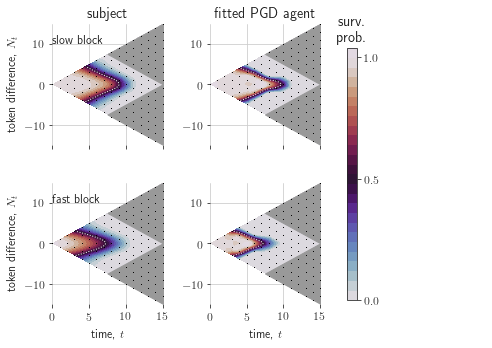

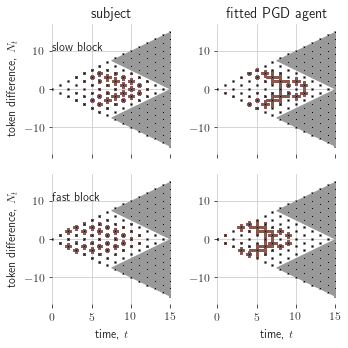

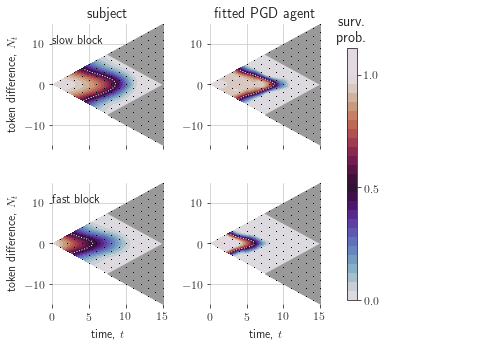

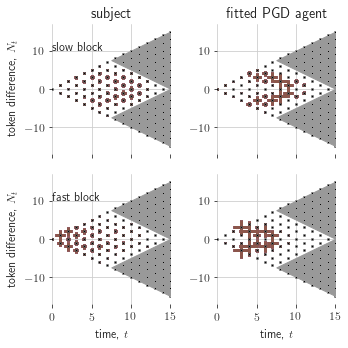

In [64]:
# model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
#             'sense_power':8.839935, 
#             'tau_long':31620.805644,
#             }
# model_paras_S2_taus={'tau_context':1.40574372e+02, 
#         'sense_power':-8.31123820e+00, 
#         'tau_long':4.60248743e+04,
#         }
model_paras_vec=[model_paras_S1_taus,model_paras_S2_taus]
sub_block_vec=[0,1]
for subject in [1,2]:
    df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)

    model_paras=model_paras_vec[subject-1]

    df_mod=get_model_output(df_act,model_paras)
    
    plot_policies({'act':df_act,'mod':df_mod},file_name='subject_'+str(subject))

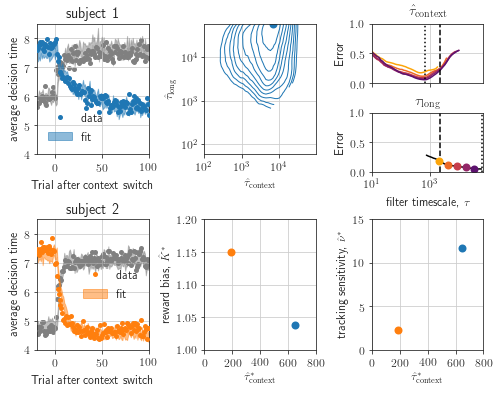

In [442]:
# error_grid=np.load('error_grid_v1_1_1000.npy')
# error_grid=np.load('error_grid_v2_1_1000.npy')
# error_grid=np.load('error_grid_v3_first20_1_1000.npy')
# error_grid=np.load('error_grid_v4_first20last20_1_1000.npy')
# error_grid=np.load('error_grid_v5_twostream_1_1000.npy')
# error_grid=np.load('error_grid_v6_Tcontextbias_1_1000.npy')
# error_grid=np.load('error_grid_v8_grid_neldermead_justtaus_1_1000.npy')

error_grid=np.load('../../output/data/error_grid_v13uniconv_opt_neldermead_both_subject1.npy')
error_grid[error_grid==0]=np.nan
paras=np.load('../../output/data/error_grid_v13uniconv_opt_neldermead_both_subject1_pvecs.npy')
tau_shortvec=paras[0]
tau_longvec=paras[1]
optinds=np.unravel_index(np.nanargmin(error_grid),(len(tau_shortvec),len(tau_longvec)))

fig=pl.figure(figsize=(8,6))
axt=fig.add_subplot(232)
average_trial_duration=22
avg_blocksize=100

# im=axt.imshow(error_grid.T,origin='lower')

x,y=np.meshgrid(np.log10(tau_shortvec),np.log10(tau_longvec))
min_err=np.nanmin(error_grid)
axt.contour(x,y,error_grid.T,levels=np.linspace(min_err,0.2,10),linewidths=1,colors='C'+str(0),linestyles='-',)

axt.plot([np.log10(tau_shortvec[optinds[0]])],[np.log10(tau_longvec[optinds[1]])],'o')
axt.set_aspect('auto')
# cbar_ax=inset_locator.inset_axes(axt,width='20%',height='50%',bbox_to_anchor=(0.63,-0.225,.3,.6),bbox_transform=axt.transAxes)
# cb=pl.colorbar(im,cax=cbar_ax)
axt.set_yticks(np.arange(2,5))
axt.set_yticklabels([r'$10^'+str(n)+'$' for n in np.arange(2,5)])
axt.set_xticks(np.arange(4))
axt.set_xticklabels([r'$10^'+str(n)+'$' for n in np.arange(1,5)])
# cb.ax.yaxis.set_ticks_position('left')
# cbar = axt.figure.colorbar(im, ax=axt,fraction=0.045)#, **cbar_kw)
# cbar_ax.set_title('Error')
axt.set_xlabel(r'$\hat{\tau}_\textrm{context}$')
axt.set_ylabel(r'$\hat{\tau}_\textrm{long}$')
axt.set_xlim(1,4)
axt.set_ylim(1+np.log10(6),4+np.log10(6))
# axt.grid(False)

ax=(fig.add_subplot(433),fig.add_subplot(436))
colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., 7))
for it,row in enumerate(error_grid[:,25::5].T):
    ax[0].plot(tau_shortvec,row,color=colorsre[it])
ax[0].set_xscale('log')
ax[0].set_ylim(0,1)
ax[0].set_xlim(1e1,7e4)
ax[0].set_xticklabels([])
ax[0].axvline(avg_blocksize*average_trial_duration,ls='--',color='k')
ax[0].axvline(tau_shortvec[optinds[0]],ls=':',color='k')
ax[0].set_ylabel('Error')
# ax[0].text(tau_shortvec[optinds[0]]*0.1,0.7,r'$\tau^*_\textrm{context}$',fontsize=14)
# ax[0].text(avg_blocksize*average_trial_duration*1.1,0.8,r'$\langle T_\textrm{block}\rangle$',fontsize=14)

# AT=AnchoredText('short',loc=2,frameon=False,prop=dict(fontsize=16))
ax[0].set_title(r'$\hat{\tau}_\textrm{context}$')
# ax[0].add_artist(AT)
ax[1].set_xlim(1e1,7e4)
ax[1].set_ylim(0,1)
# ax[1].fill_between([80000/100*average_trial_duration,ax[1].get_xlim()[1]],[ax[1].get_ylim()[0]]*2,y2=[ax[1].get_ylim()[1]]*2,color=[0.8]*3,zorder=0)
ax[1].axvline(avg_blocksize*average_trial_duration,ls='--',color='k')
ax[1].axvline(tau_longvec[optinds[1]],ls=':',color='k')
ax[1].plot(tau_longvec,error_grid[optinds[0],:],'k-')
for tit,tau in enumerate(tau_longvec[25::5]):
    ax[1].plot([tau],[error_grid[optinds[0],25+5*tit]],'o',color=colorsre[tit])
ax[1].set_xscale('log')
ax[1].set_ylabel('Error')
ax[1].set_xlabel(r'filter timescale, $\tau$')

# AT=AnchoredText(r'$\tau_\textrm{short}=\tau^*_\textrm{short}$',loc=2,frameon=False,prop=dict(fontsize=16))
ax[1].set_title(r'$\tau_\textrm{long}$')
# ax[1].text(ax[1].get_xlim()[0],ax[1].get_ylim()[1]*0.8,r'$\tau_\textrm{context}=\tau^*_\textrm{context}$')
# ax[1].add_artist(AT)
# ax[1].text(80000/100*average_trial_duration*1.1,6.25,r'$\tau_\textrm{exp}$',fontsize=14)

model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
model_paras_S2_taus={'tau_context':188,
            'sense_power':2.308, 
            'tau_long':56605,
                     'unitconv':1.15
            }
axs=[fig.add_subplot(231),fig.add_subplot(234)]
axp=fig.add_subplot(235)
axc=fig.add_subplot(236)
for sit,model_paras in enumerate([model_paras_S1_taus,model_paras_S2_taus]):
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)    
    df_mod=get_model_output(df_act,model_paras)
    axtmp=plot_transitions({'act':df_act,'mod':df_mod},ax=axs[sit],col='C'+str(sit))
    axtmp.legend(frameon=False,loc=3 if sit==0 else 5)
    axs[sit].set_ylim(4,8.5)
    axp.plot([model_paras['tau_context']],[model_paras['unitconv']],'o',label='subject '+str(sit+1))
    axc.plot([model_paras['tau_context']],[model_paras['sense_power']],'o')
#     axp=plot_transitions({'act':df_act,'mod':df_mod},ax=axs[sit])
#     axp.set_ylabel('average decision time')
# axp.legend(frameon=False)
axs[0].set_title('subject 1')
axs[1].set_title('subject 2')
axp.set_xlabel(r'$\hat{\tau}^*_\textrm{context}$')
axc.set_xlabel(r'$\hat{\tau}^*_\textrm{context}$')
axc.set_ylabel(r'tracking sensitivity, $\hat{\nu}^*$')
axp.set_ylabel(r'reward bias, $\hat{K}^*$')
axc.set_xlim(0,800)
axc.set_xticks([0,200,400,600,800])
axp.set_xticks([0,200,400,600,800])
axp.set_xlim(0,800)
axc.set_ylim(0,15)
axp.set_ylim(1,1.2)

pl.subplots_adjust(wspace=0.5,hspace=0.5)

# fig.tight_layout(pad=0)
fig.savefig('model_fitting.pdf', transparent=True,bbox_inches="tight",dpi=300)

# plot_stats({'act':df_act,'mod':df_mod},'stats_s1')


In [350]:
df_data

,Nt,seq,nPostInterval,idSubject,nCorrectChoice,tDecision,nChoiceMade,dDate,block_idx,p_plus,p_success,duration,trialRR
0,"[0, -1, -2, -1, 0, -1, -2, -1, -2, -1, 0, -1, ...","[-1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, ...",50.0,1,1,6,-1,2009-08-13 16:04:42.627,0,"[0.5, 0.395263671875, 0.29052734375, 0.3872070...","[0.5, 0.604736328125, 0.70947265625, 0.6127929...",15.75,0.047371
1,"[0, 1, 2, 1, 0, -1, -2, -3, -4, -3, -4, -3, -2...","[1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1...",50.0,1,-1,2,1,2009-08-13 16:04:46.890,0,"[0.5, 0.604736328125, 0.70947265625, 0.6127929...","[0.5, 0.604736328125, 0.70947265625, 0.6127929...",12.75,0.055645
2,"[0, -1, -2, -1, 0, -1, 0, 1, 0, 1, 0, 1, 2, 1,...","[-1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, ...",50.0,1,1,10,-1,2009-08-13 16:04:50.657,0,"[0.5, 0.395263671875, 0.29052734375, 0.3872070...","[0.5, 0.604736328125, 0.70947265625, 0.6127929...",18.75,0.026667
3,"[0, 1, 2, 1, 2, 3, 4, 5, 6, 5, 6, 7, 8, 7, 8, 7]","[1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1]",50.0,1,1,4,1,2009-08-13 16:04:55.670,0,"[0.5, 0.604736328125, 0.70947265625, 0.6127929...","[0.5, 0.604736328125, 0.70947265625, 0.6127929...",14.25,0.050918
4,"[0, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]","[1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, ...",50.0,1,1,3,1,2009-08-13 16:04:59.797,0,"[0.5, 0.604736328125, 0.70947265625, 0.8061523...","[0.5, 0.604736328125, 0.70947265625, 0.8061523...",13.50,0.059715
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213950,"[0, -1, 0, -1, -2, -1, -2, -1, -2, -3, -2, -1,...","[-1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1,...",50.0,1,-1,6,-1,2016-11-02 12:37:09.767,562,"[0.5, 0.395263671875, 0.5, 0.38720703125, 0.27...","[0.5, 0.604736328125, 0.5, 0.61279296875, 0.72...",15.75,0.047371
213951,"[0, -1, -2, -1, 0, 1, 2, 1, 2, 3, 2, 3, 4, 3, ...","[-1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1...",50.0,1,1,3,-1,2016-11-02 12:37:16.000,562,"[0.5, 0.395263671875, 0.29052734375, 0.3872070...","[0.5, 0.604736328125, 0.70947265625, 0.6127929...",13.50,0.045392
213952,"[0, -1, -2, -3, -4, -5, -4, -3, -4, -5, -4, -5...","[-1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, ...",50.0,1,-1,3,-1,2016-11-02 12:37:20.703,562,"[0.5, 0.395263671875, 0.29052734375, 0.1938476...","[0.5, 0.604736328125, 0.70947265625, 0.8061523...",13.50,0.059715
213953,"[0, 1, 0, 1, 0, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 3]","[1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -...",50.0,1,1,6,1,2016-11-02 12:37:26.750,562,"[0.5, 0.604736328125, 0.5, 0.61279296875, 0.5,...","[0.5, 0.604736328125, 0.5, 0.61279296875, 0.5,...",15.75,0.047371


In [ ]:
plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

In [ ]:
paras=np.load('opt_paras_v7_opto_neldermead_rholongTcontextbias_1_1000.npy')
paras[1]+=7
print(paras)
model_paras_S1_taus={'tau_context':paras[0],  
                'tau_context_plus':paras[2], 
                'tau_long':2e4,#1000*average_trial_duration,
                'Tcontext_bias':paras[1],
                'rho_long_bias':paras[3],
                'shared_noise_variance_factor':0,
                'tau_shared_noise':5,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
model_paras_S1_taus={'tau_context':paras[2]*3/4,#*2/4,  
                'tau_context_plus':paras[2]*3/4,#*2/4, 
                'tau_long':1e4,#1000*average_trial_duration,
                'Tcontext_bias':0,
                'rho_long_bias':0,
                'shared_noise_variance_factor':5,
                'tau_shared_noise':5,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=1)

plot_transitions({'act':df_act,'mod':df_mod})
# check_error(subject,df_data,paras)
plot_stats({'act':df_act,'mod':df_mod})
# plot_policies({'act':df_act,'mod':df_mod})

In [ ]:
plot_stats({'act':df_act,'mod':df_mod})

## neural urgency comparison

In [26]:
import scipy.io as spio

In [27]:
store_means = spio.loadmat('../../exp_data/Thura_etal_2016/store_mean.mat', squeeze_me=True)['store_mean']
store_ci = spio.loadmat('../../exp_data/Thura_etal_2016/store_ci_both_subjects.mat', squeeze_me=True)['store_ci']
store_times = spio.loadmat('../../exp_data/Thura_etal_2016/store_time.mat', squeeze_me=True)['store_time']
# col_names=mat['toktrials'].flatten().dtype.names

In [226]:
store_ci[0]

array([array([[ 16.57624276,  17.75550583],
       [ 20.3415598 ,  21.86349938],
       [ 22.34460855,  24.1570075 ],
       [ 25.47579086,  28.06576326],
       [ 27.11269854,  32.17157547],
       [111.11111111, 111.11111111]]),
       array([[23.04377982, 25.26187581],
       [23.22521955, 25.93385005],
       [24.85657871, 28.57768784],
       [25.04587286, 31.30066343],
       [26.9623586 , 35.34145193],
       [55.88235294, 55.88235294]])], dtype=object)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


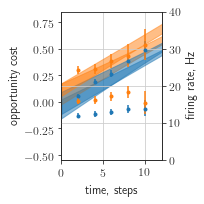

In [70]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }
# model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
#                 'sense_power':8.839935, 
#                 'tau_long':31620.805644,
#                 }
# model_paras_S1_taus={'tau_context':679.00308052 ,
#                 'tau_long':11741.3107371
#                 }
model_paras=[model_paras_S1_taus,model_paras_S2_taus]
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,1,figsize=(3,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)
ax2=ax.twinx()
tmax=12
# scale_fac=[1,0.4]
# offset=[0,-0.2]
scale_fac=[1,1]
offset=[0,0]
for sit,model_para in enumerate(model_paras):
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)
    df_mod=get_model_output(df_act,model_para)
    for bit,blocktime in enumerate(block_times):
        tmp_df=df_mod[df_mod.nPostInterval==blocktime]
        urgency_arr=tmp_df.rho_long.values[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((tmp_df.rho_context.values-tmp_df.rho_long.values)*tmp_df.T_context.values)[:,np.newaxis]
        lowb=-0.55
        highb=0.85
        ax.set_ylim(lowb,highb)
    #     binsvec=np.linspace(lowb,highb,100)
    #     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
    #     for tit in trial_time_vec:
    #         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
    #         hist_data[:,tit]=counts
        mean_urg=np.mean(urgency_arr,axis=0)
        std_urg=np.std(urgency_arr,axis=0)
    #     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
        ax.fill_between(x=np.arange(0,para['T']+1),y1=scale_fac[sit]*(mean_urg-std_urg)+offset[sit],y2=scale_fac[sit]*(mean_urg+std_urg)+offset[sit],alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

        #     hist_data[hist_data<500]=np.nan
    #     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
        ax.legend(frameon=False,prop={'size': 12},loc=4)
        ax.set_ylabel('opportunity cost')
        ax.yaxis.grid(False)
        ax.xaxis.grid(True)
        ax.set_xlim(0,tmax)
        ax.set_xlabel(r'time, steps')
        max_rate=70
        error_bars=store_ci[sit,bit]-store_means[sit,bit][:,np.newaxis]
        error_bars[:,0]*=-1
        ax2.errorbar(x=store_times[sit,bit],y=store_means[sit,bit],yerr=error_bars.T,elinewidth=1.5,fmt='o',ms=2,ecolor='C'+str(bit),color='C'+str(bit),label=strvec[bit])#/np.sqrt(urgency_arr.shape[0])

#         ax2.plot(,store_means[sit,bit],'.:',mew=2,ms=2,mfc='None',color='C'+str(bit))
        ax2.set_ylim(0,40)
        ax2.set_ylabel('firing rate, Hz')
        ax.set_ylim([lowb,highb])
# ax2.legend(frameon=False,prop={'size': 10},loc=4)
ax.set_xticks((0,5,10))

fig.tight_layout()
fig.savefig('neuralurg_tokens.pdf', transparent=True,bbox_inches="tight",dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


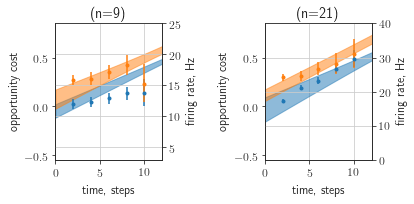

In [90]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }
# model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
#                 'sense_power':8.839935, 
#                 'tau_long':31620.805644,
#                 }
# model_paras_S1_taus={'tau_context':679.00308052 ,
#                 'tau_long':11741.3107371
#                 }
model_paras=[model_paras_S1_taus,model_paras_S2_taus]
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,2,figsize=(6,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)

tmax=12
# scale_fac=[1,0.4]
# offset=[0,-0.2]
scale_fac=[1,1]
offset=[0,0]
for sit,model_para in enumerate(model_paras):
    ax2=ax[sit].twinx()
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)
    df_mod=get_model_output(df_act,model_para)
    for bit,blocktime in enumerate(block_times):
        tmp_df=df_mod[df_mod.nPostInterval==blocktime]
        urgency_arr=tmp_df.rho_long.values[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((tmp_df.rho_context.values-tmp_df.rho_long.values)*tmp_df.T_context.values)[:,np.newaxis]
        if sit==0:
            lowb=-0.55
            highb=0.85
        else:
            lowb=-0.55
            highb=0.85
            
        ax[sit].set_ylim(lowb,highb)
    #     binsvec=np.linspace(lowb,highb,100)
    #     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
    #     for tit in trial_time_vec:
    #         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
    #         hist_data[:,tit]=counts
        mean_urg=np.mean(urgency_arr,axis=0)
        std_urg=np.std(urgency_arr,axis=0)
    #     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
        ax[sit].fill_between(x=np.arange(0,para['T']+1),y1=scale_fac[sit]*(mean_urg-std_urg)+offset[sit],y2=scale_fac[sit]*(mean_urg+std_urg)+offset[sit],alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

        #     hist_data[hist_data<500]=np.nan
    #     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
        ax[sit].legend(frameon=False,prop={'size': 12},loc=4)
        ax[sit].set_ylabel('opportunity cost')
        ax[sit].yaxis.grid(False)
        ax[sit].xaxis.grid(True)
        ax[sit].set_xlim(0,tmax)
        ax[sit].set_xlabel(r'time, steps')
        max_rate=70
        error_bars=store_ci[sit,bit]-store_means[sit,bit][:,np.newaxis]
        error_bars[:,0]*=-1
        ax2.errorbar(x=store_times[sit,bit],y=store_means[sit,bit],yerr=error_bars.T,elinewidth=1.5,fmt='o',ms=2,ecolor='C'+str(bit),color='C'+str(bit),label=strvec[bit])#/np.sqrt(urgency_arr.shape[0])

#         ax2.plot(,store_means[sit,bit],'.:',mew=2,ms=2,mfc='None',color='C'+str(bit))
        if sit==1:
            ax2.set_ylim(0,40)
        else:
            ax2.set_ylim(8,20)
            ax2.set_ylim(3,25)
        ax2.set_ylabel('firing rate, Hz')
        ax[sit].set_ylim([lowb,highb])
# ax2.legend(frameon=False,prop={'size': 10},loc=4)
        ax[sit].set_xticks((0,5,10))
    ax[sit].set_title('(n='+str(9 if sit==0 else 21)+')')

fig.tight_layout()
# fig.savefig('neuralurg_tokens.pdf', transparent=True,bbox_inches="tight",dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


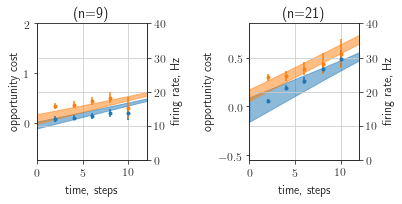

In [100]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }
# model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
#                 'sense_power':8.839935, 
#                 'tau_long':31620.805644,
#                 }
# model_paras_S1_taus={'tau_context':679.00308052 ,
#                 'tau_long':11741.3107371
#                 }
model_paras=[model_paras_S1_taus,model_paras_S2_taus]
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,2,figsize=(6,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)

tmax=12
# scale_fac=[1,0.4]
# offset=[0,-0.2]
scale_fac=[1,1]
offset=[0,0]
for sit,model_para in enumerate(model_paras):
    ax2=ax[sit].twinx()
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)
    df_mod=get_model_output(df_act,model_para)
    for bit,blocktime in enumerate(block_times):
        tmp_df=df_mod[df_mod.nPostInterval==blocktime]
        urgency_arr=tmp_df.rho_long.values[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((tmp_df.rho_context.values-tmp_df.rho_long.values)*tmp_df.T_context.values)[:,np.newaxis]
        if sit==0:
#             lowb=-0.55
#             highb=0.85
            lowb=-0.75
            highb=2
        else:
            lowb=-0.55
            highb=0.85
            
        ax[sit].set_ylim(lowb,highb)
    #     binsvec=np.linspace(lowb,highb,100)
    #     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
    #     for tit in trial_time_vec:
    #         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
    #         hist_data[:,tit]=counts
        mean_urg=np.mean(urgency_arr,axis=0)
        std_urg=np.std(urgency_arr,axis=0)
    #     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
        ax[sit].fill_between(x=np.arange(0,para['T']+1),y1=scale_fac[sit]*(mean_urg-std_urg)+offset[sit],y2=scale_fac[sit]*(mean_urg+std_urg)+offset[sit],alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

        #     hist_data[hist_data<500]=np.nan
    #     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
        ax[sit].legend(frameon=False,prop={'size': 12},loc=4)
        ax[sit].set_ylabel('opportunity cost')
        ax[sit].yaxis.grid(False)
        ax[sit].xaxis.grid(True)
        ax[sit].set_xlim(0,tmax)
        ax[sit].set_xlabel(r'time, steps')
        max_rate=70
        error_bars=store_ci[sit,bit]-store_means[sit,bit][:,np.newaxis]
        error_bars[:,0]*=-1
        ax2.errorbar(x=store_times[sit,bit],y=store_means[sit,bit],yerr=error_bars.T,elinewidth=1.5,fmt='o',ms=2,ecolor='C'+str(bit),color='C'+str(bit),label=strvec[bit])#/np.sqrt(urgency_arr.shape[0])

#         ax2.plot(,store_means[sit,bit],'.:',mew=2,ms=2,mfc='None',color='C'+str(bit))
        if sit==1:
            ax2.set_ylim(0,40)
        else:
            ax2.set_ylim(0,40)
#             ax2.set_ylim(8,20)
#             ax2.set_ylim(3,25)
        ax2.set_ylabel('firing rate, Hz')
        ax[sit].set_ylim([lowb,highb])
# ax2.legend(frameon=False,prop={'size': 10},loc=4)
        ax[sit].set_xticks((0,5,10))
    ax[sit].set_title('(n='+str(9 if sit==0 else 21)+')')

fig.tight_layout()
fig.savefig('neuralurg_tokens_separate.pdf', transparent=True,bbox_inches="tight",dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


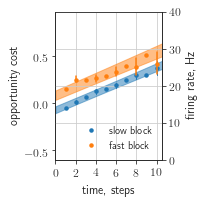

In [248]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }

model_paras=[model_paras_S1_taus,model_paras_S2_taus]
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,1,figsize=(3,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)
ax2=ax.twinx()
tmax=12
for bit,blocktime in enumerate(block_times):
    store_rho_long=np.empty((0))
    store_rho_context=np.empty((0))
    store_T_context=np.empty((0))
    for sit,model_para in enumerate(model_paras):
        df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)
        df_mod=get_model_output(df_act,model_para)
        tmp_df=df_mod[df_mod.nPostInterval==blocktime]
        store_rho_long=np.concatenate((store_rho_long,tmp_df.rho_long.values))
        store_rho_context=np.concatenate((store_rho_context,tmp_df.rho_context.values))
        store_T_context=np.concatenate((store_T_context,tmp_df.T_context.values))
        
    urgency_arr=store_rho_long[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((store_rho_context-store_rho_long)*store_T_context)[:,np.newaxis]
#     urgency_arr=np.concatenate(urgency_arr)
    lowb=-0.6
    highb=0.97
    ax.set_ylim(lowb,highb)
#     binsvec=np.linspace(lowb,highb,100)
#     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
#     for tit in trial_time_vec:
#         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
#         hist_data[:,tit]=counts
    mean_urg=np.mean(urgency_arr,axis=0)
    std_urg=np.std(urgency_arr,axis=0)
#     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
    ax.fill_between(x=np.arange(0,para['T']+1),y1=mean_urg-std_urg,y2=mean_urg+std_urg,alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

    #     hist_data[hist_data<500]=np.nan
#     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
    ax.legend(frameon=False,prop={'size': 12},loc=4)
    ax.set_ylabel('opportunity cost')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.set_xlim(0,tmax)
    ax.set_xlabel(r'time, steps')
    max_rate=70
    if bit==1:
        ax2.plot(np.arange(1,11),data_store[bit][:-1,1],'.',mew=2,ms=5,color='C'+str(bit),label=strvec[bit])
        for pit,pair in enumerate(store_ci[bit]):
            ax2.plot([2*pit+2]*2,pair,'-',color='C'+str(bit),lw=1.5)
    else:
        ax2.plot(np.arange(1,11),data_store[bit][:-1,1],'.',mew=2,ms=5,color='C'+str(bit),label=strvec[bit])
        for pit,pair in enumerate(store_ci[bit]):
            ax2.plot([2*pit+2]*2,pair,'-',color='C'+str(bit),lw=1.)
    ax2.set_ylim(0,40)
    ax2.set_xlim(0,10.5)
    ax2.set_ylabel('firing rate, Hz')
    ax.set_ylim([lowb,highb])
ax2.legend(frameon=False,prop={'size': 10},loc=4)
ax.set_xticks(np.arange(0,11,2))

fig.tight_layout()
fig.savefig('neuralurg_tokens.pdf', transparent=True,bbox_inches="tight",dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


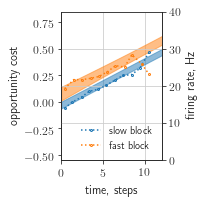

In [108]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }
model_paras_S1_taus={'tau_context':407.047901,#/average_trial_duration,
                'sense_power':8.839935, 
                'tau_long':31620.805644,
                }
model_paras_S1_taus={'tau_context':679.00308052 ,
                'tau_long':11741.3107371
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,1,figsize=(3,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)
ax2=ax.twinx()
tmax=12
for bit,blocktime in enumerate(block_times):
    tmp_df=df_mod[df_mod.nPostInterval==blocktime]
    urgency_arr=tmp_df.rho_long.values[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((tmp_df.rho_context.values-tmp_df.rho_long.values)*tmp_df.T_context.values)[:,np.newaxis]
    lowb=-0.55
    highb=0.85
    ax.set_ylim(lowb,highb)
#     binsvec=np.linspace(lowb,highb,100)
#     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
#     for tit in trial_time_vec:
#         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
#         hist_data[:,tit]=counts
    mean_urg=np.mean(urgency_arr,axis=0)
    std_urg=np.std(urgency_arr,axis=0)
#     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
    ax.fill_between(x=np.arange(0,para['T']+1),y1=mean_urg-std_urg,y2=mean_urg+std_urg,alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

    #     hist_data[hist_data<500]=np.nan
#     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
    ax.legend(frameon=False,prop={'size': 12},loc=4)
    ax.set_ylabel('opportunity cost')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.set_xlim(0,tmax)
    ax.set_xlabel(r'time, steps')
    max_rate=70
    ax2.plot(data_store[bit][:,0]/.200-0.1,data_store[bit][:,1],'.:',mew=2,ms=2,mfc='None',color='C'+str(bit),label=strvec[bit])
    ax2.set_ylim(0,40)
    ax2.set_ylabel('firing rate, Hz')
    ax.set_ylim([lowb,highb])
ax2.legend(frameon=False,prop={'size': 10},loc=4)
ax.set_xticks((0,5,10))

fig.tight_layout()
# fig.savefig('neuralurg_tokens.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [ ]:
fig,ax=pl.subplots(1,2,figsize=(6.5,3.25))
tmax=3
max_rate=70
strvec=['fast','slow']
ax2=ax[0].twinx()
for it in range(2):
    if it==0:
        p=ax2.plot(fast_dat[:,0],fast_dat[:,1],'.',label=strvec[it]+' block')
    else:
        p=ax2.plot(slow_dat[:,0],slow_dat[:,1],'.',label=strvec[it]+' block')
ax[0].set_ylim(-0.2,1.1)
ax2.set_ylim(0,max_rate)
ax2.legend(frameon=False,prop={'size': 12},loc=4)
ax[0].set_ylabel('opportunity cost')
ax[0].yaxis.grid(False)
ax[0].xaxis.grid(True)
ax[0].set_xlim(0,tmax)
ax[0].set_xlabel(r'time, $s$')
fig.tight_layout()

In [23]:
fast_dat=np.asarray([[0.10000000000000009, 19.235021459227468],
[0.3186666666666669, 21.66266094420601],
[0.5106666666666668, 21.643090128755368],
[0.724, 22.010472103004297],
[0.9213333333333331, 22.506094420600864],
[1.124, 23.77442060085837],
[1.3159999999999998, 25.428669527897],
[1.5346666666666664, 25.04944206008584],
[1.7053333333333334, 28.376824034334767],
[1.94, 25.96377682403434],
[2.1159999999999997, 23.162575107296142]])
fast_dat_upper=np.asarray([[0.3179401993355482, 22.464436035882827],
[0.7272425249169436, 22.995365843288976],
[1.120598006644518, 25.11338803622295],
[1.5299003322259135, 27.35912588750478],
[1.9338870431893684, 28.91390672165299]])
fast_dat_lower=np.asarray([[0.3179401993355482, 20.85200459164151],
[0.7166112956810631, 20.973598061306916],
[1.120598006644518, 22.50278474554653],
[1.5299003322259135, 22.93133795331831],
[1.9338870431893684, 23.027252242676756]])
slow_dat=np.asarray([[0.10000000000000009, 13.930300429184552],
[0.27600000000000025, 15.558283261802579],
[0.5106666666666668, 16.98214592274678],
[0.6813333333333336, 18.455450643776828],
[0.9053333333333331, 19.080686695278974],
[1.092, 20.116738197424894],
[1.3053333333333335, 21.51416309012876],
[1.492, 22.781974248927042],
[1.7053333333333334, 23.0206008583691],
[1.8973333333333335, 24.67484978540773],
[2.1213333333333333, 29.085493562231765]])
slow_dat_lower=np.asarray([[0.2754152823920266, 15.170783555120956],
[0.6794019933554818, 17.928489434973002],
[1.0887043189368768, 19.45759108881425],
[1.4873754152823917, 21.882658050252964],
[1.891362126245847, 22.87436758641214]])
slow_dat_upper=np.asarray([[0.2807308970099669, 16.09208792143191],
[0.6847176079734221, 19.028952850644103],
[1.0833887043189367, 20.788571914459418],
[1.4873754152823917, 23.751030993580205],
[1.891362126245847, 26.585519323158028]])

## Statistics

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


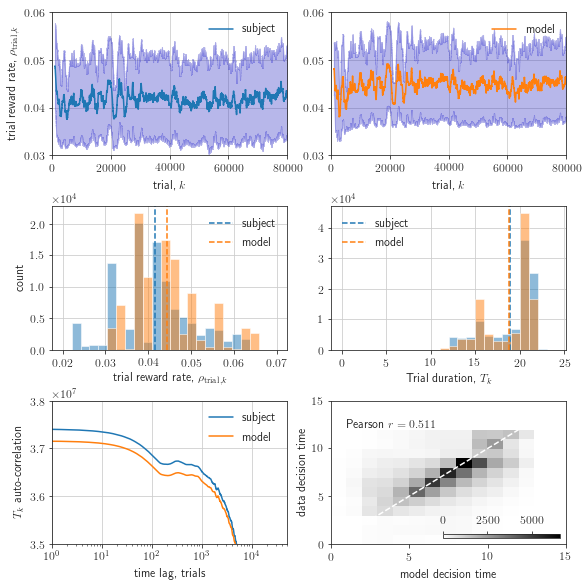

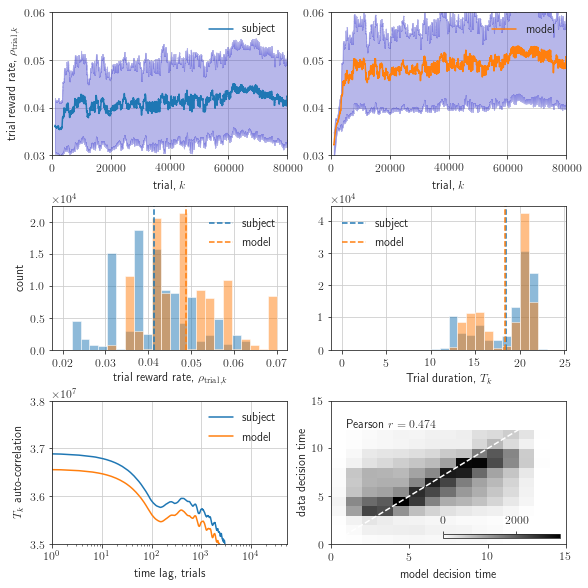

In [166]:
model_paras_S1_taus={'tau_context':646,
            'sense_power':11.703220, 
            'tau_long':45248,
                     'unitconv':1.0386
            }
model_paras_S2_taus={'tau_context':188,
            'sense_power':2.308, 
            'tau_long':56605,
                     'unitconv':1.15
            }


for sit,model_paras in enumerate([model_paras_S1_taus,model_paras_S2_taus]):
    df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)    
    df_mod=get_model_output(df_act,model_paras)
    plot_stats({'act':df_act,'mod':df_mod},'stats_subj_'+str(sit+1))

for sit, subject in enumerate(range(1,3)):
    df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
    df_mod=get_model_output(df_act,model_paras_S1_taus)

## Policy and transitions

In [ ]:
# for sit, subject in enumerate(range(1,3)):
plot_policies({'act':df_act,'mod':df_mod})

Switching analysis

In [ ]:
for sit, subject in enumerate(range(1,3)):
    fig,ax=pl.subplots(2,3,figsize=(12,4))
    for j,dtype in enumerate(data_type):
        df_tmp=data_store[subject][dtype]
        df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    
        #group transitions by fast-to-slow and slow-to-fast 
        dirstrvec=['fast to slow','slow to fast']
        for dit,interval in enumerate(block_times):
            time_depth=50
            history=20
            cond=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==interval))
            num_samples=cond.sum()
            print(num_samples)
            data_st=np.zeros((num_samples,time_depth+history))
            for it,ind in enumerate(cond[cond].index.values):
                data_st[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values
            
            binvec=np.linspace(0,14,20)
            trial_time_vec=np.arange(-history,time_depth)
            halfmaxes=np.zeros(len(trial_time_vec))
            colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., len(trial_time_vec)))
            for it in range(len(trial_time_vec)):
                counts,bins=np.histogram(data_st[:,it],bins=binvec)
                cum=np.cumsum(counts)/np.sum(counts)
                ax[j,dit].plot(binvec[:-1],cum,color=colorsre[it])
                maxind=np.where(0.5<cum)[0][0]
                xmin=binvec[maxind-1]
                xmax=binvec[maxind]
                m=(cum[maxind]-cum[maxind-1])/(xmax-xmin)
                halfmaxes[it]=(0.5-cum[maxind-1])/m+xmin#np.max(counts)
                ax[j,dit].plot([halfmaxes[it]],[0.5],'o',color=colorsre[it])
            ax[j,2].plot(trial_time_vec,halfmaxes,'.-')
            ax[j,2].fill_between([-history,0],[3]*2,[9]*2,color=[0.7]*3,alpha=0.5)
            ax[j,2].set_ylim(3,9)
            ax[0,dit].set_title(dirstrvec[dit])
        ax[j,0].set_ylim(0.45,0.55)
        ax[j,1].set_ylim(0.45,0.55)
    fig.tight_layout()
#         fig.savefig('halfmax_data'+str(i)+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

## Context unaware

In [17]:
root_filename='v13unaware_opt_neldermead_justfastslowmodel_subject1'
root_dir='../../output/data/'
run_evaluation('opt',1,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

Iter      taul      unitconv  
1 9500.000000 1.050000 
2 9500.000000 1.050000 
3 9812.500000 1.037500 
4 9312.500000 1.037500 
5 9531.250000 1.043750 
6 9031.250000 1.043750 
7 9031.250000 1.043750 
8 8796.875000 1.040625 
9 8796.875000 1.040625 
10 7929.687500 1.039062 
11 7929.687500 1.039062 
12 6971.679688 1.040039 
13 6971.679688 1.040039 
14 4279.296875 1.037891 
15 4279.296875 1.037891 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


16 2104.492188 1.038477 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


17 1586.914062 1.035742 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


18 1586.914062 1.035742 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


19 628.906250 1.036719 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


20 111.328125 1.033984 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


21 111.328125 1.033984 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


22 111.328125 1.033984 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


23 65.917969 1.035254 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


24 65.917969 1.035254 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


25 65.917969 1.035254 


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: overflow encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:89: RuntimeWarning: overflow encountered in double_scalars
  return tmp*filtered_value+(1-tmp)*input_sample
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:95: RuntimeWarning: invalid value encountered in multiply
  return rho_long*trial_time_vec
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_lib.py:137: RuntimeWarning: invalid value encountered in less_equal
  if len(np.where(min_regret<=opp_cost)[0])>0:


26 65.917969 1.035254 
27 65.917969 1.035254 
28 65.917969 1.035254 
29 85.857391 1.034428 
30 85.857391 1.034428 
31 78.653336 1.035032 
32 78.653336 1.035032 
33 78.653336 1.035032 
34 78.653336 1.035032 
35 78.653336 1.035032 
36 78.653336 1.035032 
37 78.653336 1.035032 
38 78.653336 1.035032 
39 78.653336 1.035032 
40 78.653336 1.035032 
41 78.653336 1.035032 
42 78.653336 1.035032 
43 78.653336 1.035032 
44 78.653336 1.035032 
45 78.653336 1.035032 
46 78.653336 1.035032 
47 78.653336 1.035032 
48 78.653336 1.035032 
49 78.653336 1.035032 
50 78.653336 1.035032 
51 78.653336 1.035032 
52 78.653336 1.035032 
53 78.653336 1.035032 
54 78.653336 1.035032 
Optimization terminated successfully.
         Current function value: 0.310021
         Iterations: 55
         Function evaluations: 133
opt took 381.6506357192993
[78.65333557  1.03503227]
saved in ../../output/data/opt_paras_v13unaware_opt_neldermead_justfastslowmodel_subject1.npy


In [37]:
root_filename='v13unaware_opt_neldermead_justfastslowmodel_subject2'
root_dir='../../output/data/'
run_evaluation('opt',2,df_data,root_dir,root_filename,model_type='slow_to_fast_only')

Iter      taul      unitconv  
1 90.000000 1.075000 
2 85.000000 1.187500 
3 62.500000 1.293750 
4 57.500000 1.406250 
5 57.500000 1.406250 
6 57.500000 1.406250 
7 50.312500 1.417969 
8 44.453125 1.462305 
9 44.453125 1.462305 
10 44.453125 1.462305 
11 44.453125 1.462305 
12 46.958008 1.447351 
13 45.645752 1.448947 
14 45.645752 1.448947 
15 45.645752 1.448947 
16 45.645752 1.448947 
17 45.843315 1.447963 
18 45.679283 1.448162 
19 45.679283 1.448162 
20 45.703526 1.448505 
21 45.539494 1.448704 
22 45.539494 1.448704 
23 45.539494 1.448704 
24 45.375462 1.448904 
25 45.471921 1.448693 
26 45.423691 1.448799 
27 45.389905 1.448793 
28 45.389905 1.448793 
29 45.389905 1.448793 
30 45.389905 1.448793 
31 45.389905 1.448793 
32 45.389905 1.448793 
33 45.389905 1.448793 
34 45.390970 1.448794 
35 45.390970 1.448794 
36 45.390970 1.448794 
37 45.390970 1.448794 
38 45.390970 1.448794 
39 45.390970 1.448794 
Optimization terminated successfully.
         Current function value: 0.435126
 

some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:239: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:239: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:239: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/dyn_opp_cost/code/lib/filter_plotting.py:239: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


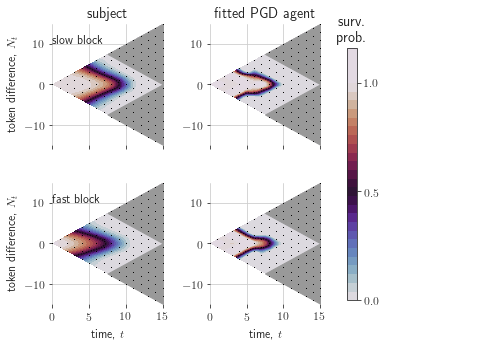

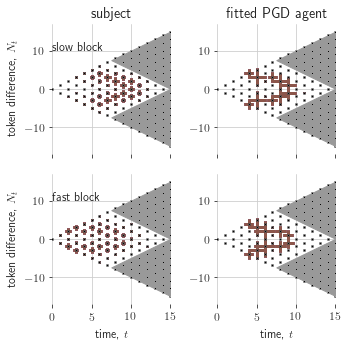

In [36]:
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)

model_paras={'tau_long':340,'unitconv':1.03}

df_mod=get_model_output(df_act,model_paras)
plot_policies({'act':df_act,'mod':df_mod},file_name='subject_1')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


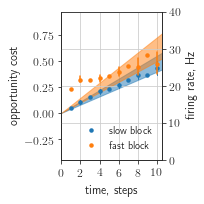

In [42]:
# opt_paras=np.load('../../output/data/opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
# model_paras_S1_taus={'tau_context':opt_paras[0],  
#                 'tau_context_plus':opt_paras[0], 
#                 'tau_long':opt_paras[1],
#                 'Tcontext_bias':0,
#                 'shared_noise_variance_factor':0,
#                 'tau_shared_noise':1,
#                 'context_noise_bias':0,
#                 'context_noise_variance_factor':0
#                 }

# model_paras=[model_paras_S1_taus,model_paras_S2_taus]
model_paras=[{'tau_long':78.653336,'unitconv':1.03},{'tau_long':45.4,'unitconv':1.45}]#_S1_taus,model_paras_S2_taus]

trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,1,figsize=(3,3))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)
ax2=ax.twinx()
tmax=12
for bit,blocktime in enumerate(block_times):
    store_rho_long=np.empty((0))
    store_rho_context=np.empty((0))
    store_T_context=np.empty((0))
    for sit,model_para in enumerate(model_paras):
#         if sit==0:
        df_act=df_data[df_data.idSubject==sit+1].reset_index(drop=True)
        df_mod=get_model_output(df_act,model_para)
        tmp_df=df_mod[df_mod.nPostInterval==blocktime]
        store_rho_long=np.concatenate((store_rho_long,tmp_df.rho_long.values))
        store_rho_context=np.concatenate((store_rho_context,tmp_df.rho_context.values))
        store_T_context=np.concatenate((store_T_context,tmp_df.T_context.values))
        
    urgency_arr=store_rho_long[:,np.newaxis]*trial_time_vec[np.newaxis,:]#+((store_rho_context-store_rho_long)*store_T_context)[:,np.newaxis]
#     urgency_arr=np.concatenate(urgency_arr)
    lowb=-0.45
    highb=0.97
    ax.set_ylim(lowb,highb)
#     binsvec=np.linspace(lowb,highb,100)
#     hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
#     for tit in trial_time_vec:
#         counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
#         hist_data[:,tit]=counts
    mean_urg=np.mean(urgency_arr,axis=0)
    std_urg=np.std(urgency_arr,axis=0)
#     ax.errorbar(x=np.arange(0,para['T']+1)*0.2+0.1,y=mean_urg,yerr=np.std(urgency_arr,axis=0),elinewidth=1.5,fmt='o',ms=0,ecolor='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])
    ax.fill_between(x=np.arange(0,para['T']+1),y1=mean_urg-std_urg,y2=mean_urg+std_urg,alpha=0.5,color='C'+str(bit))#/np.sqrt(urgency_arr.shape[0])

    #     hist_data[hist_data<500]=np.nan
#     ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
    ax.legend(frameon=False,prop={'size': 12},loc=4)
    ax.set_ylabel('opportunity cost')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.set_xlim(0,tmax)
    ax.set_xlabel(r'time, steps')
    max_rate=70
    if bit==1:
        ax2.plot(np.arange(1,11),data_store[bit][:-1,1],'.',mew=2,ms=5,color='C'+str(bit),label=strvec[bit])
        for pit,pair in enumerate(store_ci[bit]):
            ax2.plot([2*pit+2]*2,pair,'-',color='C'+str(bit),lw=1.5)
    else:
        ax2.plot(np.arange(1,11),data_store[bit][:-1,1],'.',mew=2,ms=5,color='C'+str(bit),label=strvec[bit])
        for pit,pair in enumerate(store_ci[bit]):
            ax2.plot([2*pit+2]*2,pair,'-',color='C'+str(bit),lw=1.)
    ax2.set_ylim(0,40)
    ax2.set_xlim(0,10.5)
    ax2.set_ylabel('firing rate, Hz')
#     ax.set_ylim([lowb,highb])
ax2.legend(frameon=False,prop={'size': 10},loc=4)
ax.set_xticks(np.arange(0,11,2))

fig.tight_layout()
fig.savefig('neuralurg_tokens_trial_unaware.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [ ]:
store_rho_long[:,np.newaxis]